# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 


### Problem Statement
Used car dealerships need to price vehicles competitively while maximizing profit. Pricing too high can reduce demand, while pricing too low can reduce margins.

### Business Objective
Identify which vehicle attributes (such as year, mileage, fuel type, transmission, etc.) have the strongest influence on used car prices.

### Success Criteria
- Build regression models that reasonably predict car prices
- Identify key drivers of vehicle value
- Provide actionable insights that a dealership could use for pricing strategy

In [633]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib as mpl

import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.express as px
from typing import List, Optional, Dict, Tuple



In [634]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA


from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', None)
mpl.rcParams['figure.figsize'] = (25, 7)  # Default figure size
mpl.rcParams['savefig.dpi'] = 300  # Higher DPI for better quality
mpl.rcParams['figure.dpi'] = 100  # Screen display DPI


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

The dataset contains used vehicle listings with both numerical and categorical attributes. Before modeling, it is important to understand the structure, quality, and limitations of the data.


Load Data

In [635]:
df = pd.read_csv("data/vehicles.csv")
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


Data Overview and Analysis

In [636]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [637]:
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


# Initial Observation
df.describe()


### Initial Observations

- The dataset includes both numerical and categorical variables
- The target variable `price` contains missing and invalid values
- Some features have wide ranges and potential outliers



### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In this stage, we clean the data and prepare it for modeling. This includes:
- Removing invalid records
- Handling missing values
- Separating features and target variables

In [638]:
# Clean target variable

df = df.dropna(subset=["price"])
df = df[df["price"] > 0]

In [639]:
# Missing Value check

df.isnull().sum().sort_values(ascending=False).head(10)


size            282933
cylinders       160410
VIN             152158
condition       151389
drive           120254
paint_color     117149
type             85932
manufacturer     16185
title_status      7734
model             4701
dtype: int64

In [640]:

# Print percentage of Columns that are null in relation to the total number of columns
for column in df.columns:
    if df[column].isnull().sum() > 0:
        print(column, ': {:.2%}'.format(df[column].isnull().sum() /
                                               df[column].shape[0]))

year : 0.30%
manufacturer : 4.11%
model : 1.19%
condition : 38.43%
cylinders : 40.71%
fuel : 0.66%
odometer : 0.58%
title_status : 1.96%
transmission : 0.46%
VIN : 38.62%
drive : 30.52%
size : 71.81%
type : 21.81%
paint_color : 29.73%


 Check the number of null columns

In [641]:
df.isnull().sum()


id                   0
region               0
price                0
year              1173
manufacturer     16185
model             4701
condition       151389
cylinders       160410
fuel              2594
odometer          2290
title_status      7734
transmission      1823
VIN             152158
drive           120254
size            282933
type             85932
paint_color     117149
state                0
dtype: int64

There are a lot of missing values based on the above percentage and count comparison table. The next step is to ensure we normalize those data and ensuring that the data is valid before proceeding to any other comparison charts and analysis

First step is to drop all empty data as this can affect the modelling


In [642]:
df  = df.dropna() # Drops all empty datasets
df.isnull().sum() # Checks the empty cells after dropping


id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
VIN             0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

In [643]:
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
268,7315946365,birmingham,9000,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al
337,7315354216,birmingham,8950,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,1FTMF1CM6BKD55331,fwd,full-size,truck,white,al
338,7315349921,birmingham,4000,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al


## Remove outliers

## Price Outliers
Based on the various statistical analysis methods, keep data that are relevant and remove all outliers

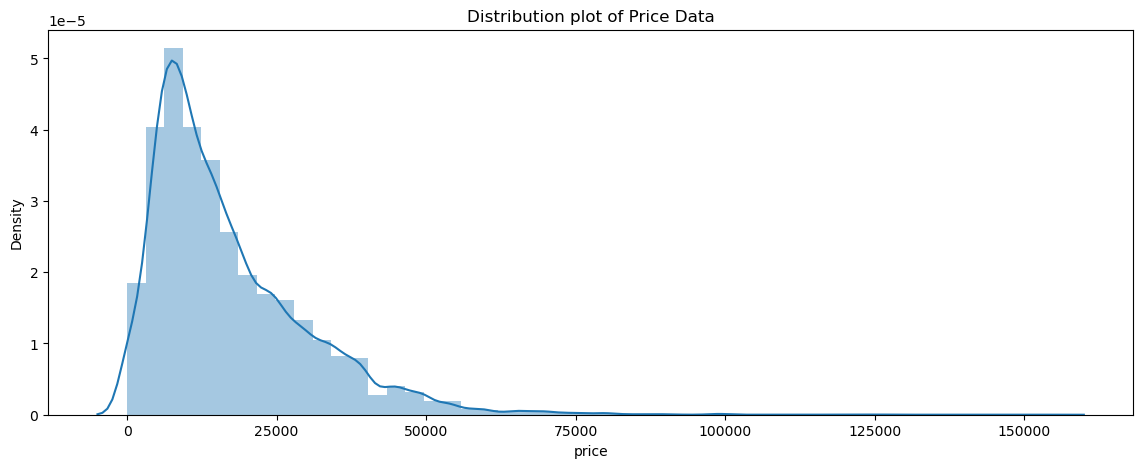

In [644]:
#  Lets check price distribution before clean up
#Distribution plot of the price feature
plt.figure(figsize=(14,5))
sns.distplot(df['price']).set(title = 'Distribution plot of Price Data')

plt.savefig('./images/clean_price.png')
plt.show()

In [645]:
# Maximum, Minimum, Std dev and Mean value of price in the dataframe
print('Max:', df['price'].max())
print('Min:', df['price'].min())
print('Mean:', df['price'].mean())
print('Std deviation:', df['price'].std())


Max: 155000
Min: 1
Mean: 16993.479012801574
Std deviation: 13219.39489002664


Based on the results above, we can remove any vehicle sold above 150000 and below 100 to help when we perform an outlier test

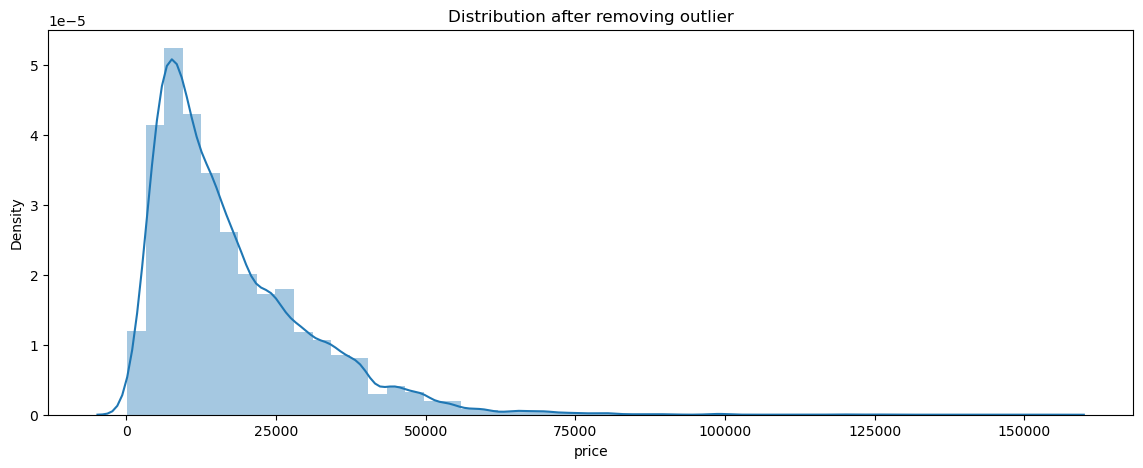

In [646]:
df_price = df[(df['price'] < 1500000) & (df['price'] > 100)]

#Distribution plot of the price feature after removing very high outliers
plt.figure(figsize=(14,5))
sns.distplot(df_price['price']).set(title = 'Distribution after removing outlier')

plt.savefig('./images/clean_price1.png')
plt.show()

In [647]:
print('Max:', df_price['price'].max())
print('Min:', df_price['price'].min())
print('Mean:', df_price['price'].mean())
print('Std. Dev.:', df_price['price'].std())

#Upper and lower bounds for outliers
print("Highest allowed",df_price['price'].mean() + 3*df_price['price'].std())
print("Lowest allowed",df_price['price'].mean() - 3*df_price['price'].std())

Max: 155000
Min: 116
Mean: 17377.340644471016
Std. Dev.: 13116.089320382629
Highest allowed 56725.60860561891
Lowest allowed -21970.927316676873


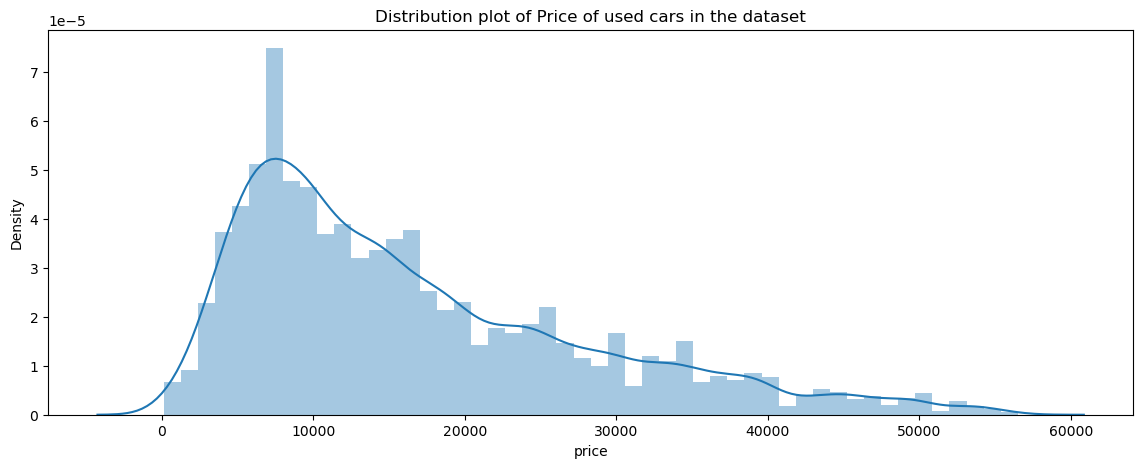

In [648]:
df = df_price[(df_price['price'] < 56680) & (df_price['price'] > -21946)]
#Distribution plot of the price after adjustment
plt.figure(figsize=(14,5))
sns.distplot(df['price']).set(title = 'Distribution plot of Price of used cars in the dataset')
plt.savefig('./images/clean_price2.png')
plt.show()


## Adjusting Year Data

In [649]:
print('Max:', df['year'].max())
print('Min:', df['year'].min())
print('Mean:', df['year'].mean())
print('Std. Dev.:', df['year'].std())

#Upper and lower bounds for outliers
print("Highest allowed",df['year'].mean() + 3*df['year'].std())
print("Lowest allowed",df['year'].mean() - 3*df['year'].std())

# Dropping all years below 2026 and above 1983
df = df[(df['year'] < 2022) & (df['year'] > 1983)]


Max: 2022.0
Min: 1905.0
Mean: 2010.777483739319
Std. Dev.: 7.218752435852298
Highest allowed 2032.4337410468759
Lowest allowed 1989.1212264317621


All the empty data sets are removed. Next step is to remove columns with 0 value especially for the price data as it is invalid


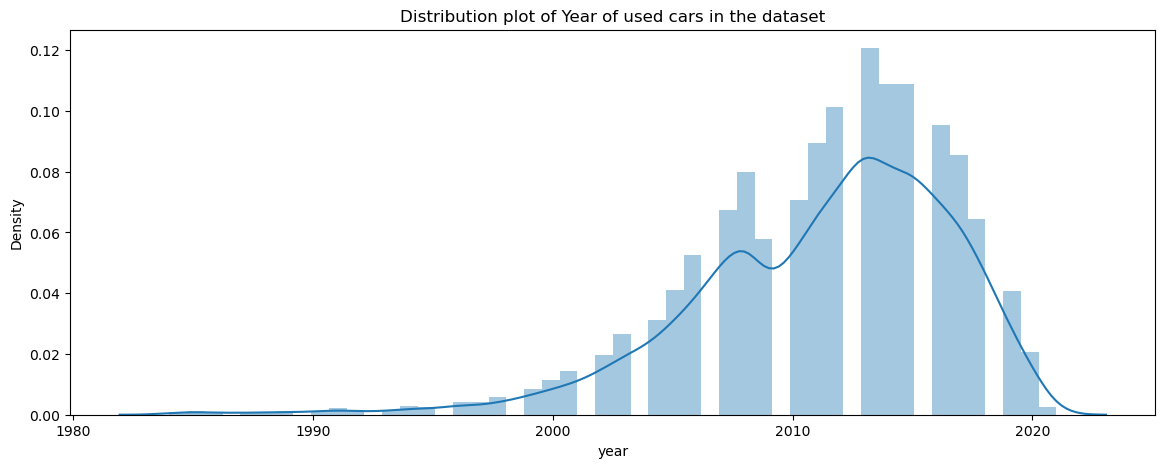

In [650]:
plt.figure(figsize=(14,5))
sns.distplot(df['year']).set(title = 'Distribution plot of Year of used cars in the dataset')
plt.savefig('./images/clean_year.png')
plt.show()

In [651]:
df.eq(0).any()

id              False
region          False
price           False
year            False
manufacturer    False
model           False
condition       False
cylinders       False
fuel            False
odometer         True
title_status    False
transmission    False
VIN             False
drive           False
size            False
type            False
paint_color     False
state           False
dtype: bool

Only Odometer has the zero values. They are safe to be removed

In [652]:
# verify the impact before removing odometer data. We dont want to remove a significantly large data
count = (df['odometer'] == 0).sum()
print('Invalid odometer count : ', count)

Invalid odometer count :  54


In [653]:
# verify the impact before removing price data. We dont want to remove a significantly large data
count = (df['price'] == 0).sum()
print('Invalid odometer count : ', count)

Invalid odometer count :  0


Removing odometer data with 0 as value. Price is cean so no action needed

In [654]:

df.drop(df[df['odometer'] == 0].index, inplace = True)
count = (df['odometer'] == 0).sum()
print('Invalid odometer count : ', count)

# Now the invalid count is 0 and the data is good to proceed

Invalid odometer count :  0


In [655]:
# Final check for any empty or zeros

df.eq(0).any().unique() # all False -> Good to proceed


array([False])

In [656]:
# Check Year Data
df.year.unique()



array([2002., 1995., 2008., 2011., 2007., 2017., 2019., 2013., 2014.,
       2018., 2015., 2010., 2004., 2020., 2001., 2016., 2006., 2009.,
       2005., 1998., 2012., 2000., 2003., 1991., 2021., 1994., 1999.,
       1996., 1997., 1989., 1985., 1987., 1992., 1990., 1984., 1986.,
       1993., 1988.])

Year Data is not valid as it has decimals and extra characters. Need to convert this into a readable format

In [657]:
def get_range(year):
    period_start = int(year/5) * 5
    period_end = period_start+4
    range5 = f"{period_start} - {period_end}"
    return range5

df['year_range'] = df['year'].apply(get_range)

df['year_range'].unique()

array(['2000 - 2004', '1995 - 1999', '2005 - 2009', '2010 - 2014',
       '2015 - 2019', '2020 - 2024', '1990 - 1994', '1985 - 1989',
       '1980 - 1984'], dtype=object)

Price Distribution

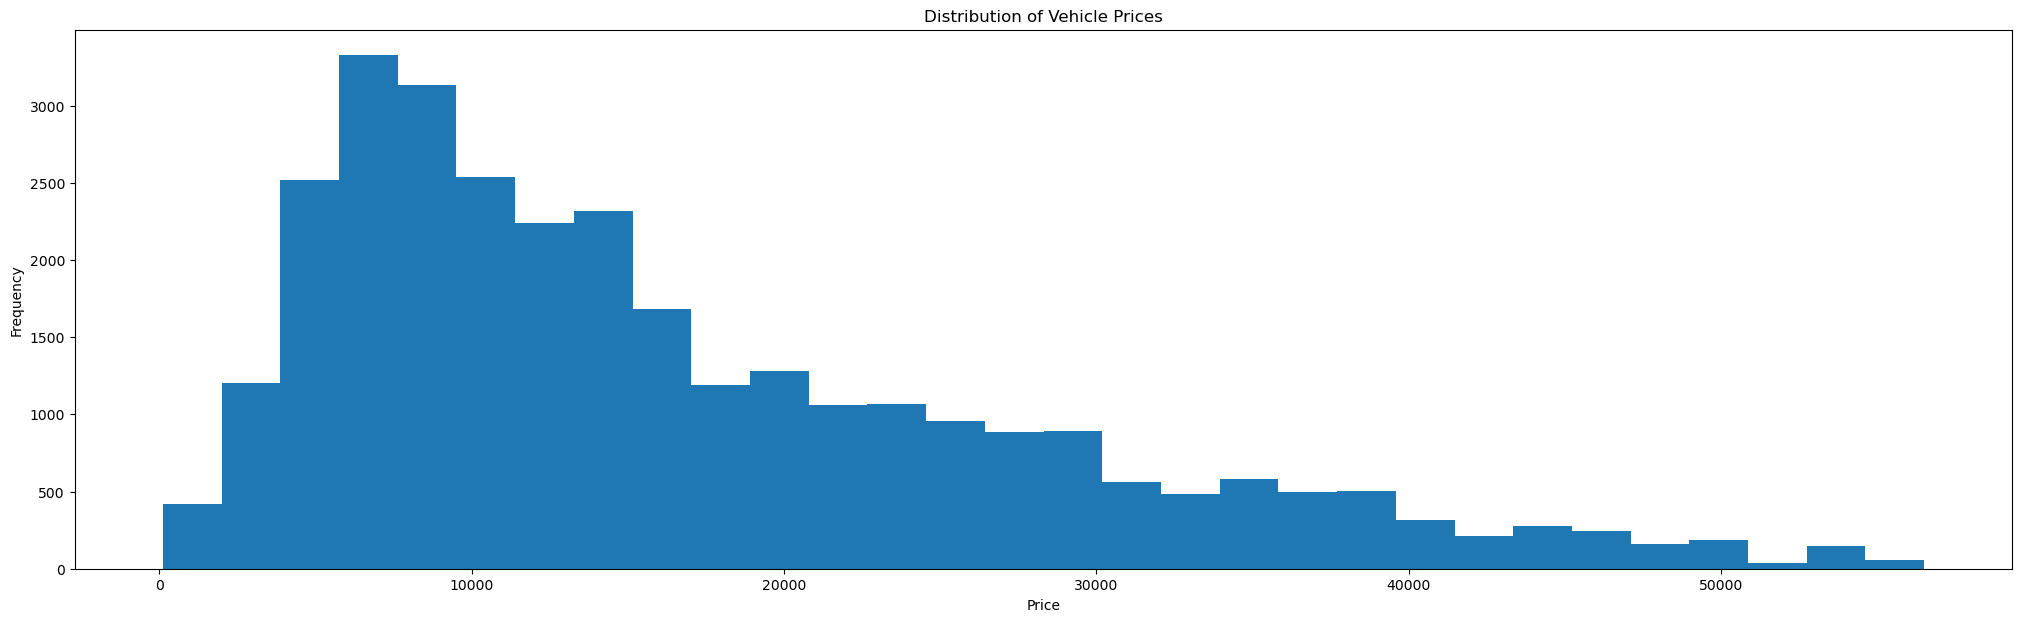

In [658]:
plt.hist(df["price"], bins=30)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of Vehicle Prices")

plt.savefig('./images/vehicle_prices.png')
plt.show()

In [659]:
df['paint_color'].value_counts()
 # More vehicles of white color


paint_color
white     8627
black     5702
silver    4303
grey      3811
blue      3002
red       2783
custom     828
green      807
brown      725
yellow     188
orange     137
purple      64
Name: count, dtype: int64

In [660]:
df['type'].value_counts()
#  More SUV vehicles in the data and less of bus, offroad and mini vans etc


type
SUV            8464
sedan          7468
truck          6609
pickup         2420
van            1632
coupe          1184
hatchback      1083
convertible     725
wagon           611
mini-van        585
other            80
offroad          75
bus              41
Name: count, dtype: int64

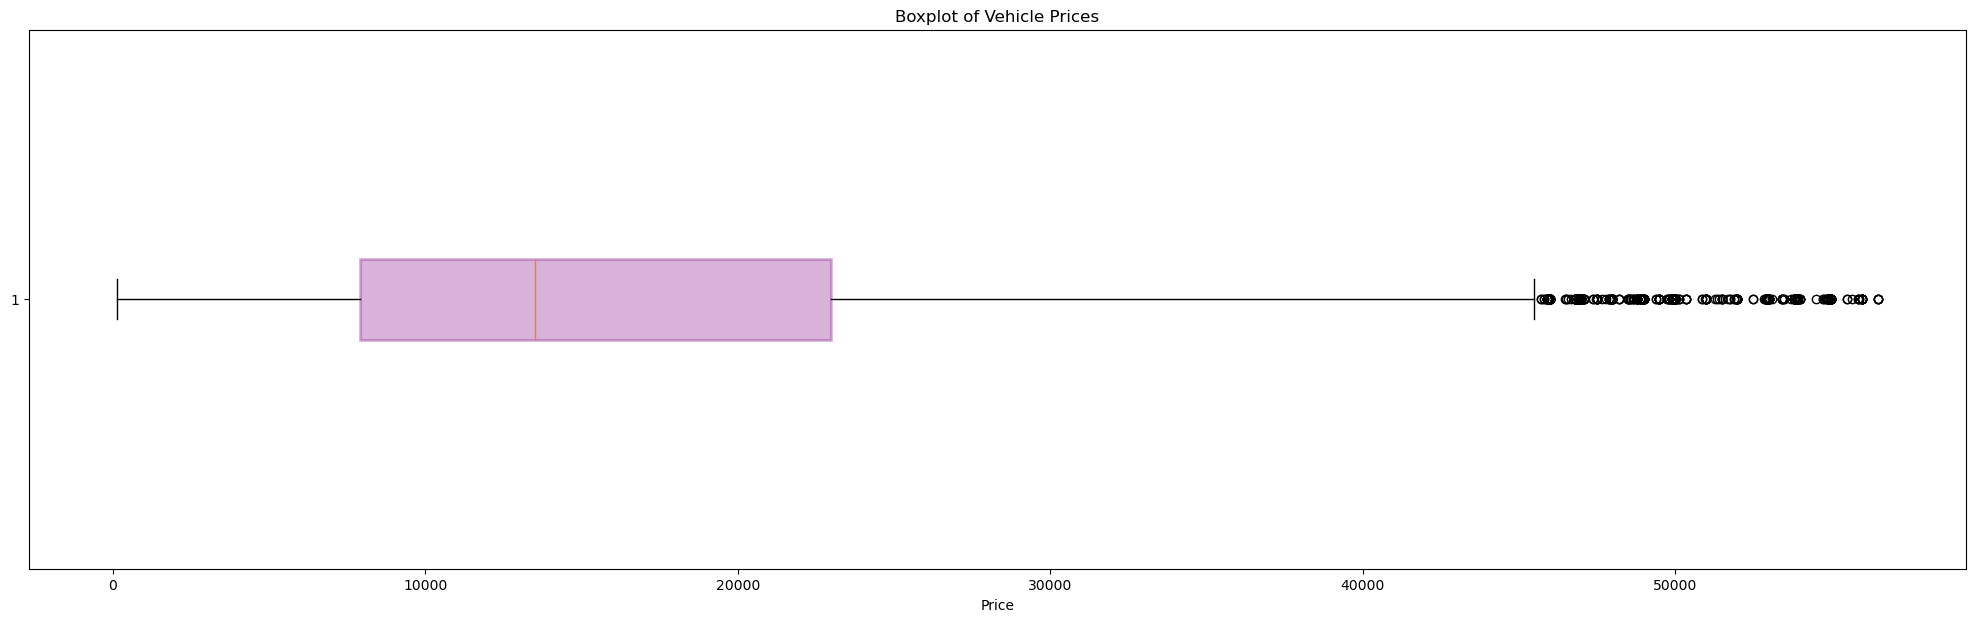

In [661]:



boxplot = plt.boxplot(df["price"], vert=False, patch_artist=True)

for box in boxplot['boxes']:
    box.set(color='purple', linewidth=2)
    box.set(facecolor='purple', alpha=0.3)  # Set fill color with some transparency

plt.title("Boxplot of Vehicle Prices")
plt.xlabel("Price")
plt.savefig('./images/vboxplt_price.png')
plt.show()

Year vs Price

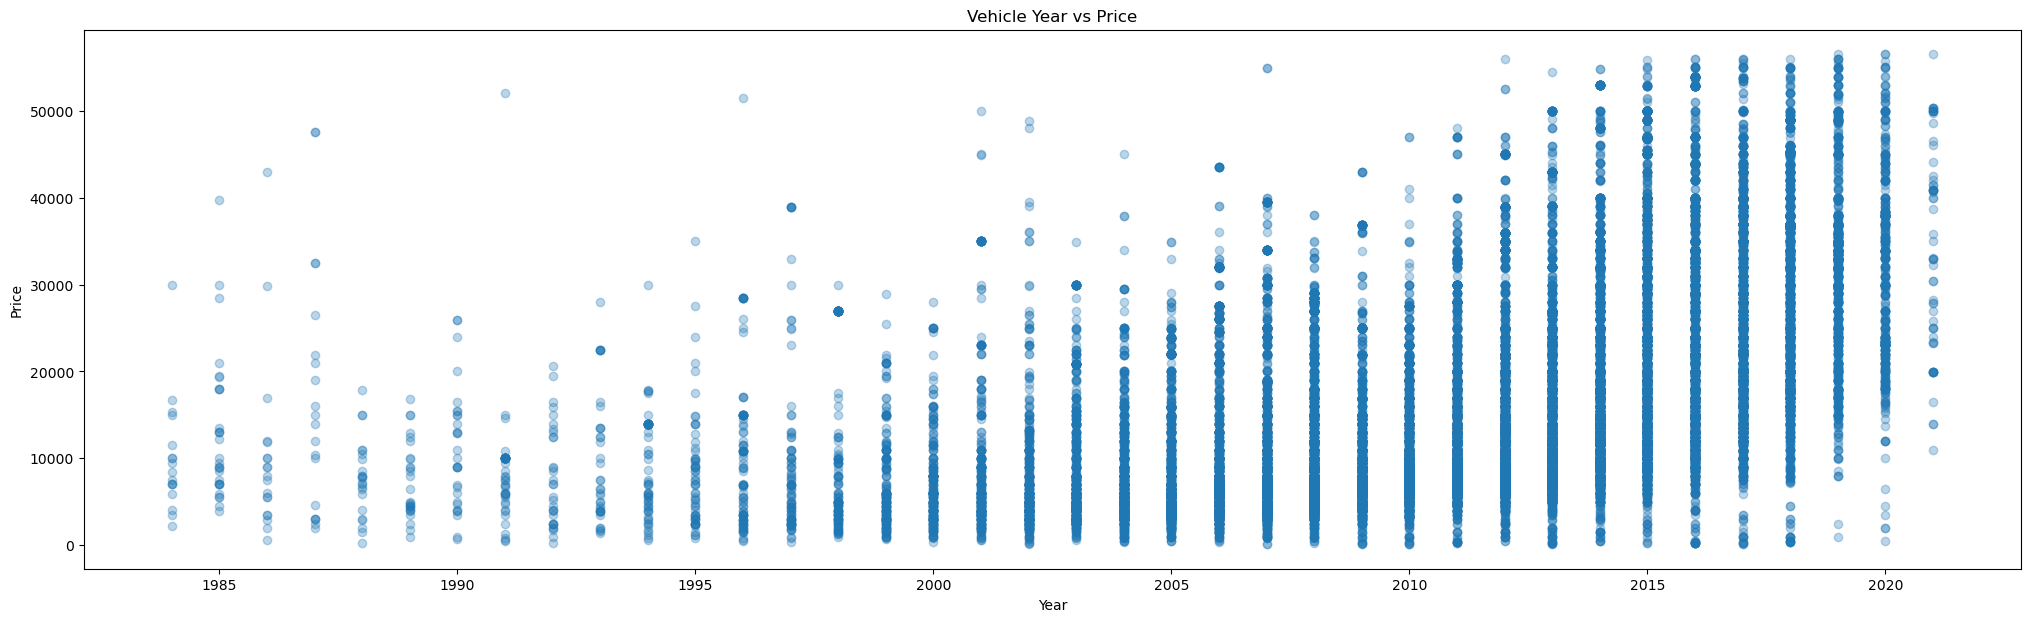

In [662]:
plt.scatter(df["year"], df["price"], alpha=0.3)
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Vehicle Year vs Price")
plt.savefig('./images/scatter_veh_price.png')
plt.show()

Odometer vs Price Scatter Plot

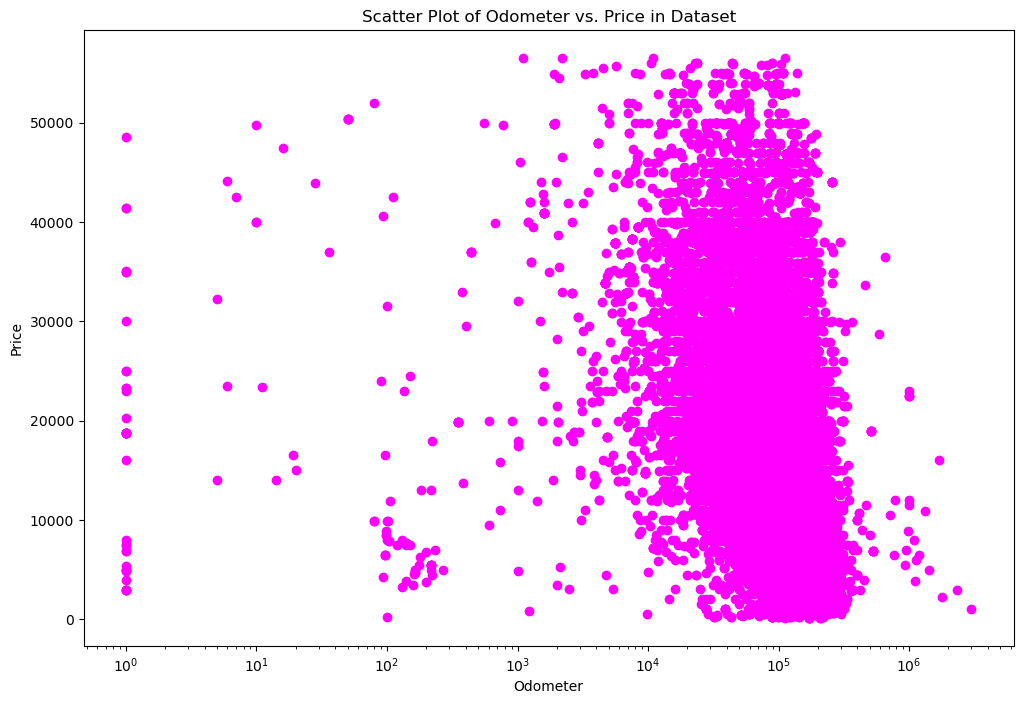

In [663]:
fig, ax = plt.subplots(figsize=(12,8))
plt.xscale("log") 
ax.scatter(df['odometer'], df['price'], color=['magenta'])
ax.set_title('Scatter Plot of Odometer vs. Price in Dataset')
ax.set_xlabel('Odometer')
ax.set_ylabel('Price')

plt.savefig('./images/scatter_odo_price.png')
plt.show()

Car Condition vs Price

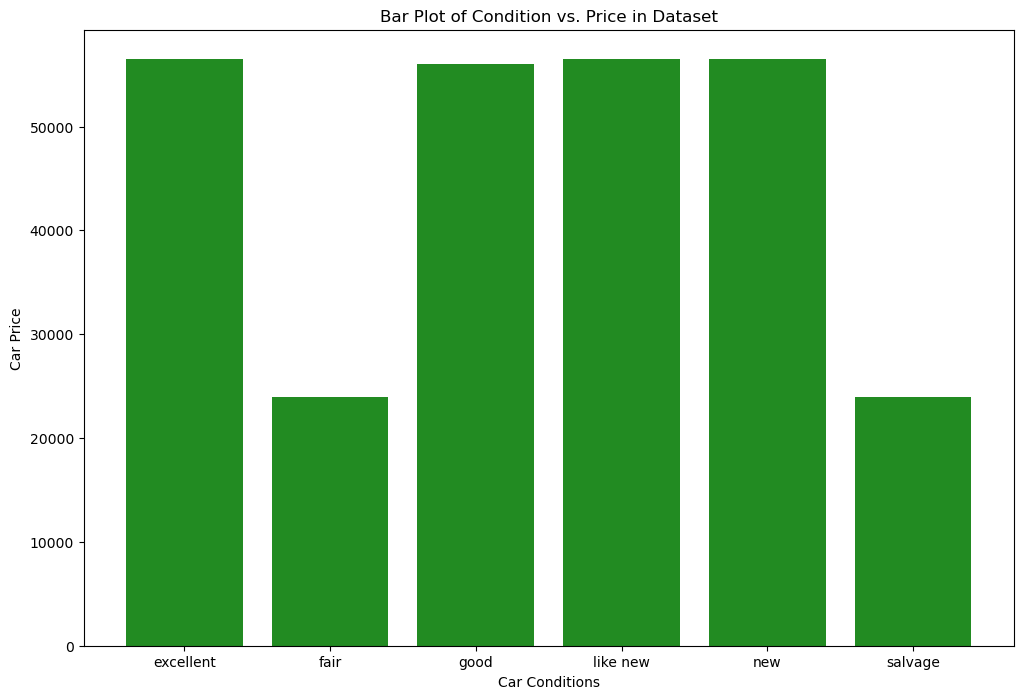

In [664]:
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(df["condition"],df["price"], color='forestgreen')
# set a title and labels
ax.set_title('Bar Plot of Condition vs. Price in Dataset')
ax.set_xlabel('Car Conditions')
ax.set_ylabel('Car Price')

plt.savefig('./images/price_condition_bar.png')
plt.show()

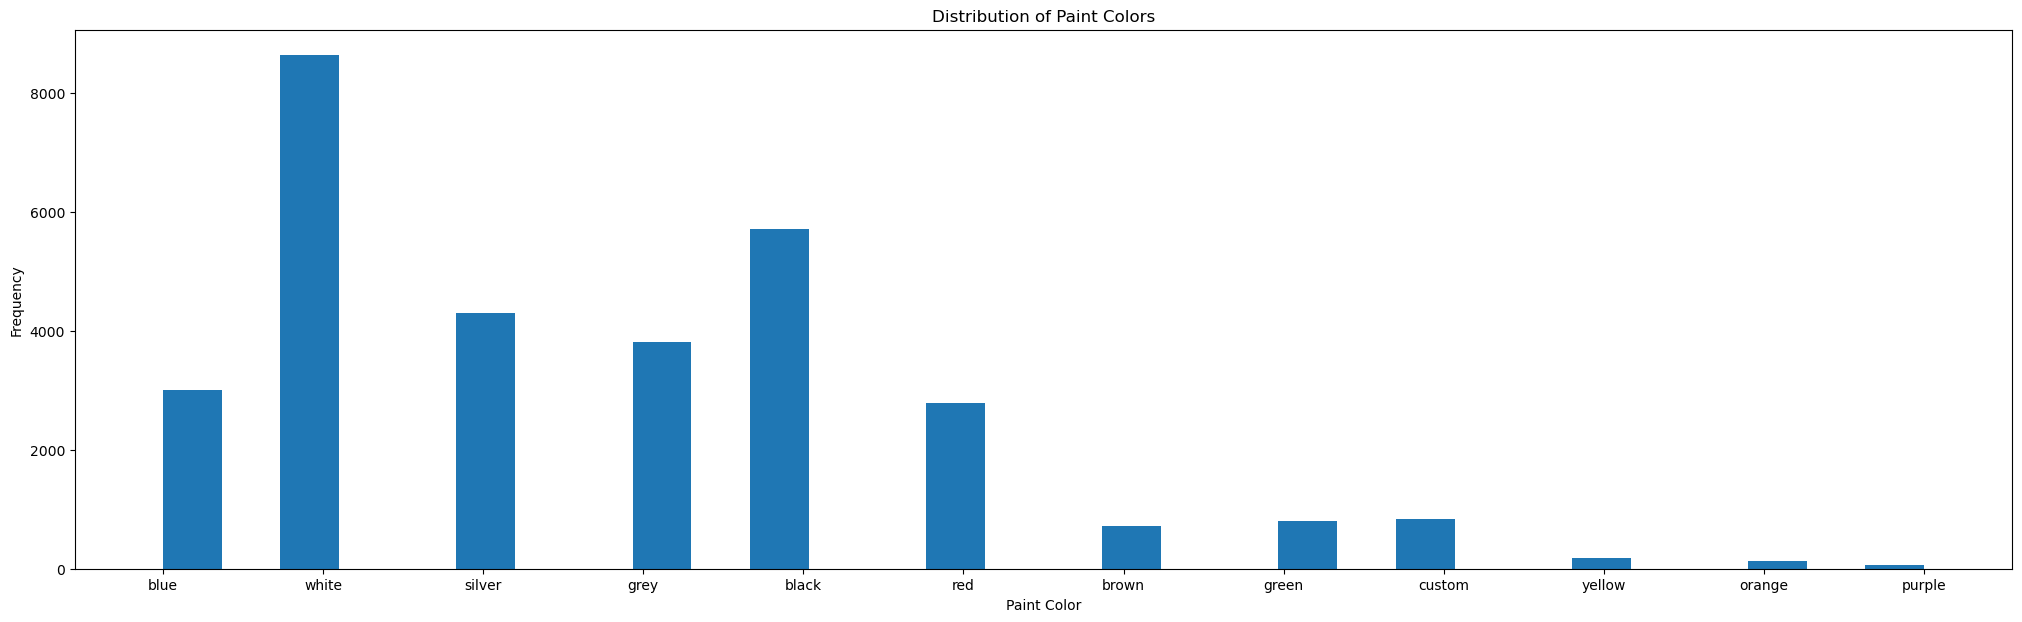

In [724]:
plt.hist(df["paint_color"], bins=30)
plt.xlabel("Paint Color")
plt.ylabel("Frequency")
plt.title("Distribution of Paint Colors")

plt.savefig('./images/hist_paint_price.png')
plt.show()

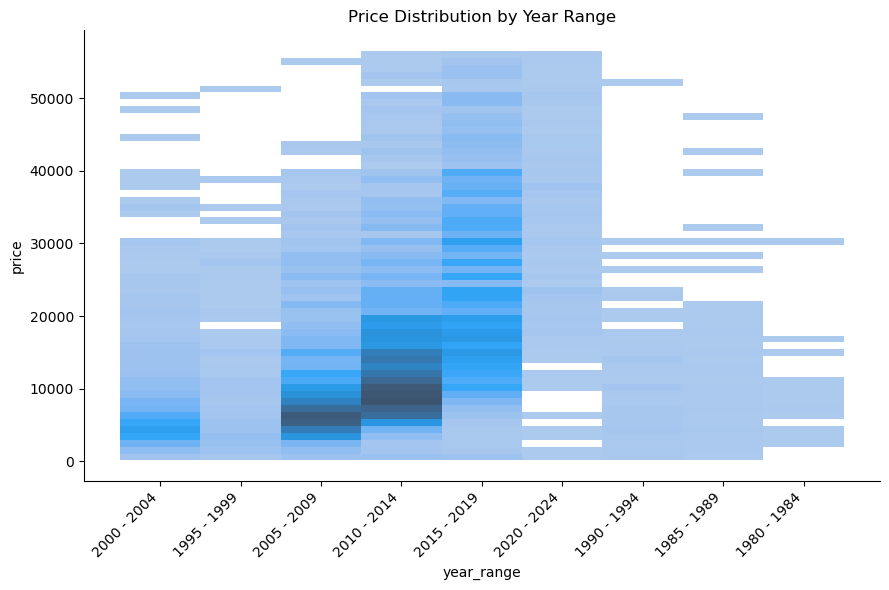

In [666]:
sns.displot(x="year_range",
            y="price",
            kind="hist",  
            height=6, 
            aspect=1.5,
            data=df)
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them

# Adjust the bottom margin to make room for rotated labels
plt.subplots_adjust(bottom=0.2)

# Add title and ensure proper layout
plt.title("Price Distribution by Year Range")
plt.tight_layout() 
plt.savefig('./images/price_year_range.png')
plt.show()

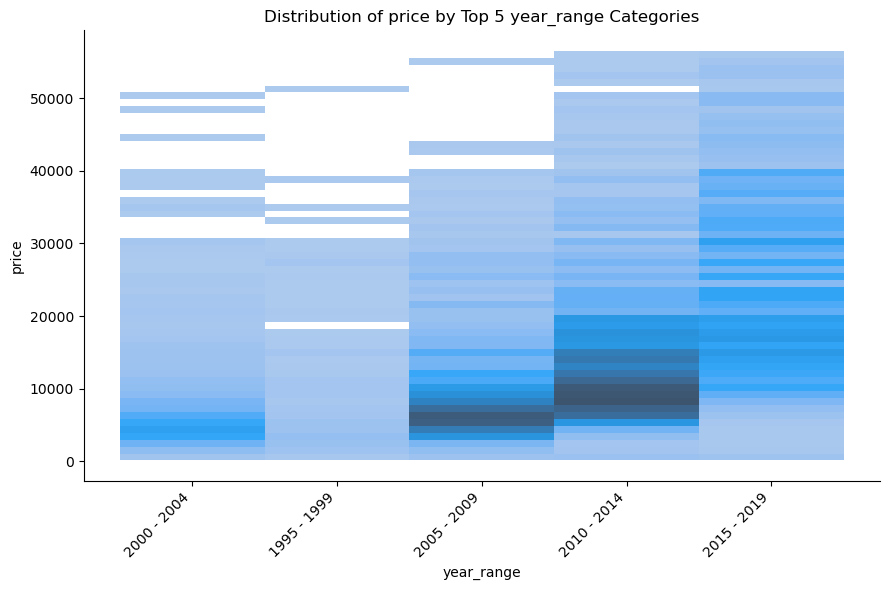

In [667]:

def plot_top_categories_distribution(
    data: pd.DataFrame, 
    category_column: str, 
    count_column: str = "price", 
    top_n: int = 5
) -> None:
    """
    Plot distribution of prices for top N categories with highest counts.
    
    Args:
        data: DataFrame containing the data
        category_column: Column name to group by and find top categories
        count_column: Column to count and analyze (default: "price")
        top_n: Number of top categories to include (default: 5)
    """
    # Get the top N categories with highest counts
    top_categories = (
        data[category_column]
        .value_counts()
        .nlargest(top_n)
        .index
        .tolist()
    )
    
    # Filter the dataframe to include only these top categories
    filtered_df = data[data[category_column].isin(top_categories)]
    
    # Create the distribution plot
    plot = sns.displot(
        data=filtered_df,
        x=category_column,
        y=count_column,
        kind="hist",
        height=6,
        aspect=1.5
    )
    
    # Improve label readability
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.2)
    
    # Add informative title
    plt.title(f"Distribution of {count_column} by Top {top_n} {category_column} Categories")
    plt.tight_layout()
    
    return plot

plot_top_categories_distribution(df, category_column="year_range")

plt.savefig('./images/price_year_range1.png')


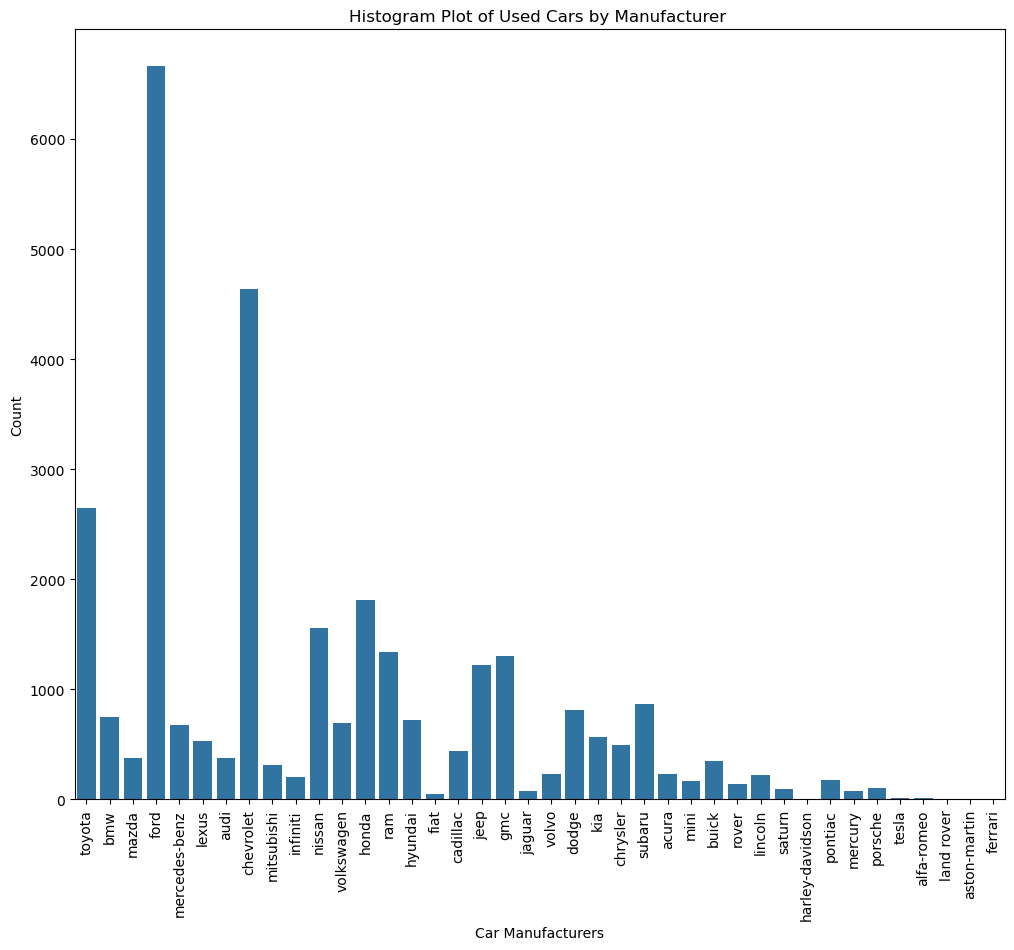

<Figure size 2500x700 with 0 Axes>

In [668]:
# Plot the number of used car counts by manufacturer

fig, ax = plt.subplots(figsize=(12,10))

#create seaborn boxplot
ax = sns.countplot(x='manufacturer', data=df , ax=ax)

# Adding Title to the Plot
ax.set_title("Histogram Plot of Used Cars by Manufacturer ")

#rotate x-axis and y-axis tick labels
plt.xticks(rotation=90)
    
   
# Setting the X and Y labels
ax.set_xlabel("Car Manufacturers")
ax.set_ylabel("Count")

plt.show()
plt.savefig('./images/price_manuf.png')


Fuel Type

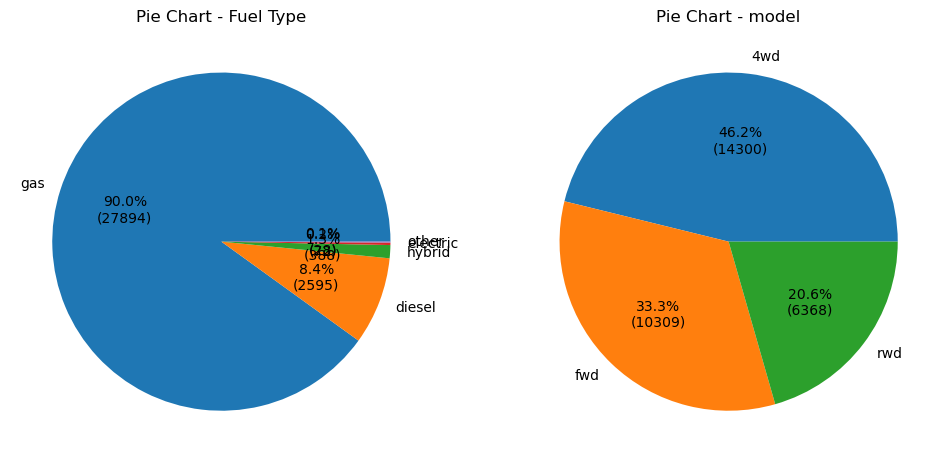

<Figure size 2500x700 with 0 Axes>

In [669]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

# plot each pie chart in a separate subplot

ax1.set_title('Pie Chart - Fuel Type')
s = df['fuel'].value_counts()
ax1.pie(s,labels = s.index,  autopct=autopct_format(s))

ax2.set_title('Pie Chart - model')
s = df['drive'].value_counts()
ax2.pie(s,labels = s.index, autopct=autopct_format(s))

plt.show()
plt.savefig('./images/price_fule.png')


Putting together the main aspects that can affect price price

Top categories selected for analysis:
year_range: 2010 - 2014
type: SUV
condition: excellent
odometer: 145000.0
cylinders: 4 cylinders


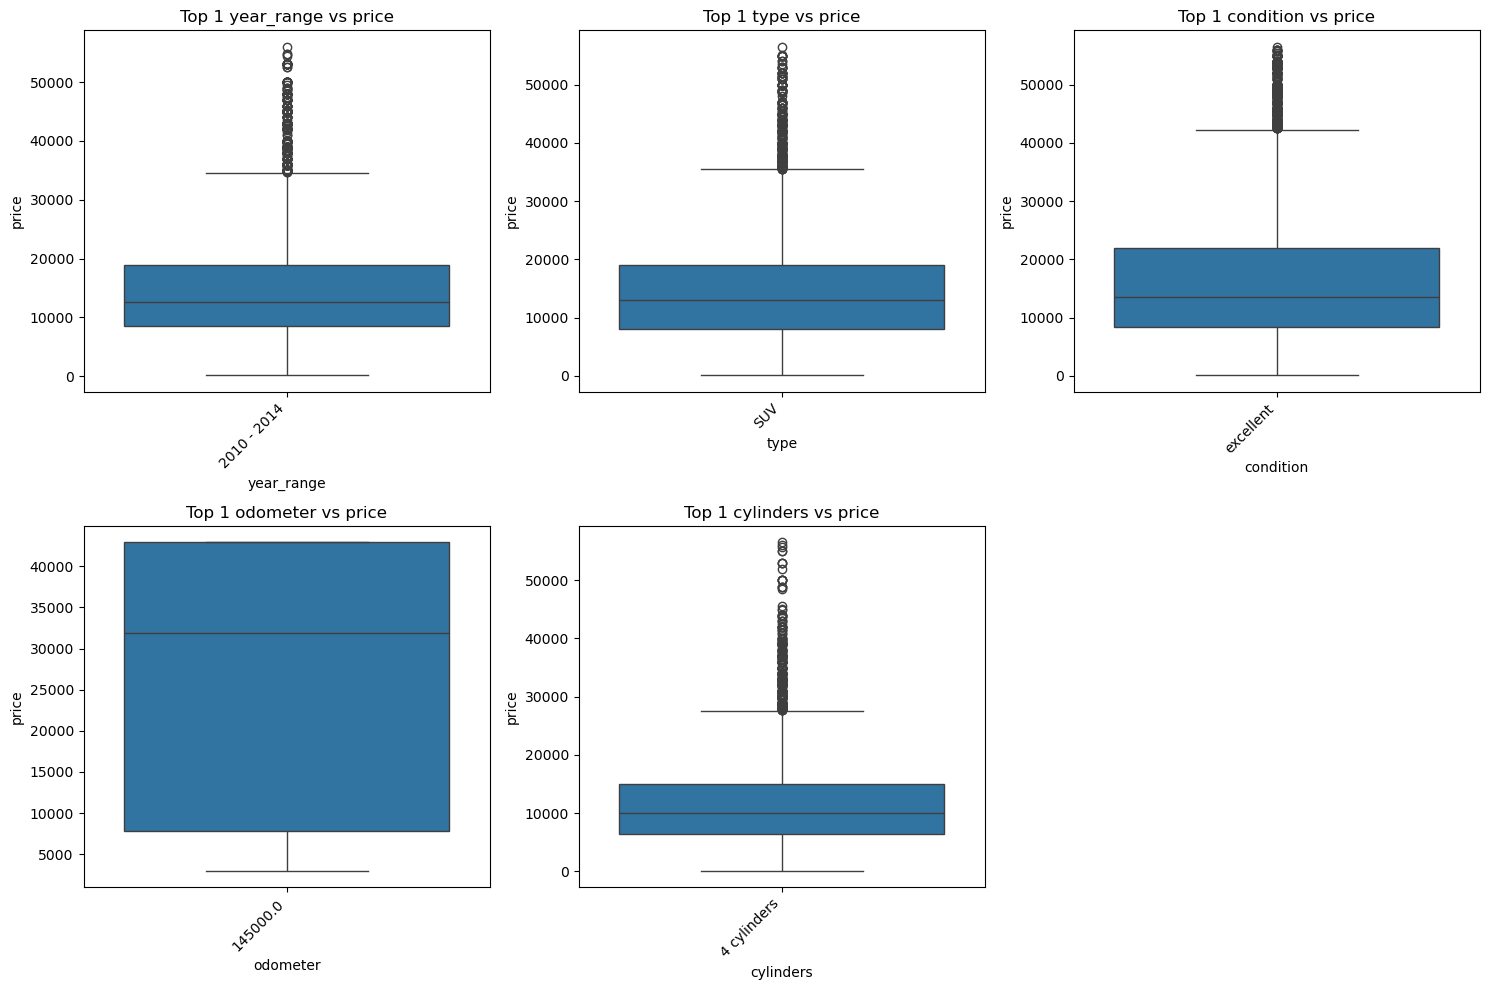

In [670]:


def plot_top_categories_vs_price(
    data: pd.DataFrame,
    category_columns: List[str],
    price_column: str = "price",
    top_n: int = 1,
    figsize: Tuple[int, int] = (15, 10)
) -> None:
    """
    Plot distribution of prices for top categories across multiple columns.
    
    Args:
        data: DataFrame containing the data
        category_columns: List of column names to analyze top categories from
        price_column: Column containing price data to analyze
        top_n: Number of top categories to include from each column (default: 1)
        figsize: Size of the figure as (width, height) in inches
    """
    # Calculate number of subplots needed
    n_cols = min(3, len(category_columns))
    n_rows = (len(category_columns) + n_cols - 1) // n_cols
    
    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows * n_cols == 1:  # Handle single subplot case
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Store top categories for summary
    top_categories_dict = {}
    
    # Create a subplot for each category column
    for i, column in enumerate(category_columns):
        if i < len(axes):
            ax = axes[i]
            
            # Get the top N categories with highest counts
            top_categories = (
                data[column]
                .value_counts()
                .nlargest(top_n)
                .index
                .tolist()
            )
            top_categories_dict[column] = top_categories
            
            # Filter the dataframe to include only these top categories
            filtered_df = data[data[column].isin(top_categories)]
            
            # Create boxplot to compare price distributions
            sns.boxplot(x=column, y=price_column, data=filtered_df, ax=ax)
            
            # Improve label readability
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            ax.set_title(f"Top {top_n} {column} vs {price_column}")
            
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    
    # Print summary of which top categories were selected
    print("Top categories selected for analysis:")
    for col, cats in top_categories_dict.items():
        print(f"{col}: {', '.join(str(c) for c in cats)}")
    
    return fig

plot_top_categories_vs_price(df, category_columns=["year_range", "type", "condition", "odometer", "cylinders"], top_n=1)

plt.savefig('./images/multi-cat-price.png')


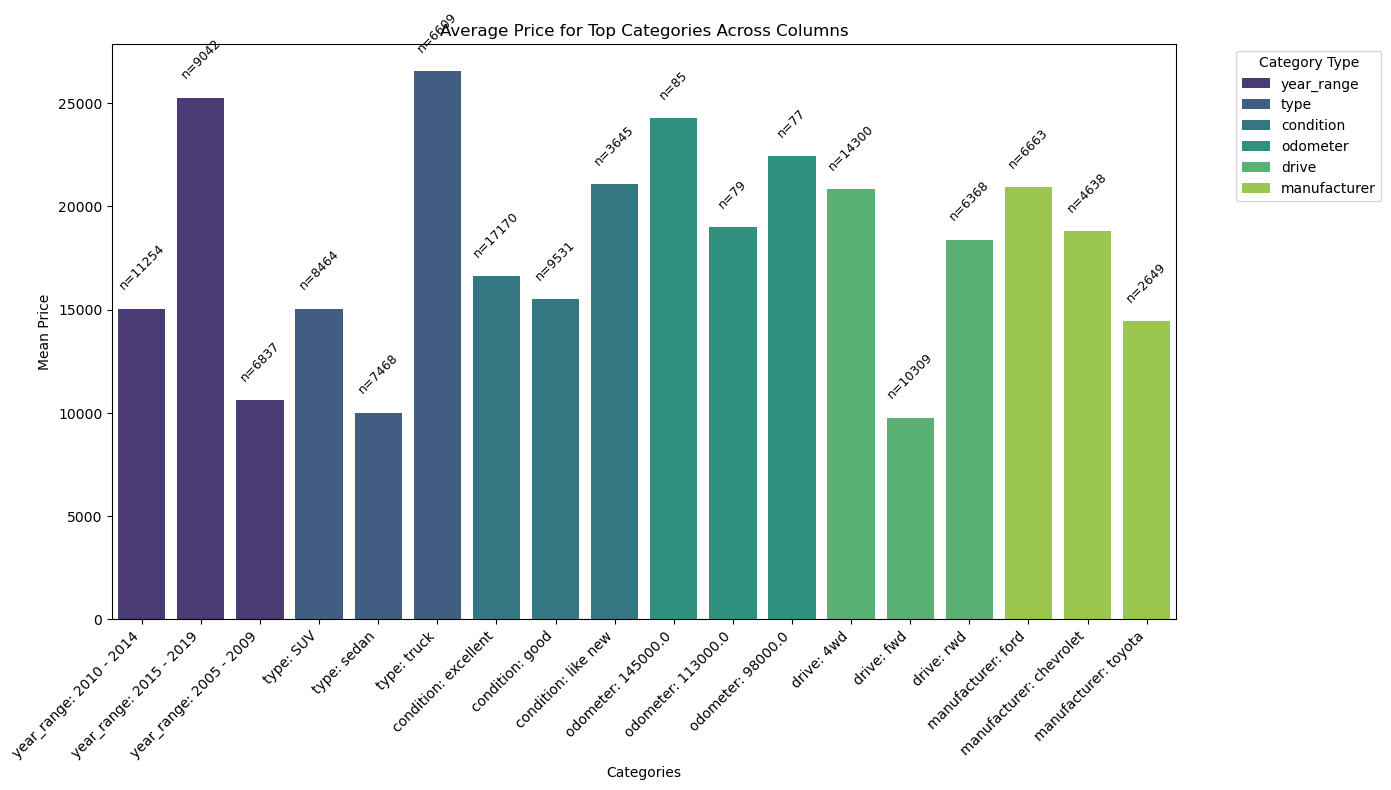

In [671]:

def plot_top_categories_price_barchart(
    data: pd.DataFrame,
    category_columns: List[str],
    price_column: str = "price",
    top_n: int = 1,
    figsize: Tuple[int, int] = (12, 8),
    clear_previous: bool = True,
    ax: Optional[plt.Axes] = None,
    label_rotation: int = 45  # Added parameter for label rotation
) -> plt.Figure:
    """
    Plot mean prices for top categories across multiple columns as a bar chart.
    
    Args:
        data: DataFrame containing the data
        category_columns: List of column names to analyze top categories from
        price_column: Column containing price data to analyze
        top_n: Number of top categories to include from each column (default: 1)
        figsize: Size of the figure as (width, height) in inches
        clear_previous: Whether to clear previous plots (default: True)
        ax: Optional matplotlib Axes object to plot on
        label_rotation: Rotation angle for count labels on top of bars (default: 45)
        
    Returns:
        matplotlib Figure object
    """
    # Clear previous plots if requested
    if clear_previous:
        plt.clf()
        plt.close('all')
    
    # Create a results dataframe to hold the data for plotting
    results = []
    
    # Process each category column
    for column in category_columns:
        # Get the top N categories with highest counts
        top_categories = (
            data[column]
            .value_counts()
            .nlargest(top_n)
            .index
            .tolist()
        )
        
        # For each top category, calculate price statistics
        for category in top_categories:
            category_data = data[data[column] == category]
            
            # Skip if no data
            if len(category_data) == 0:
                continue
                
            # Add to results
            results.append({
                'Category Column': column,
                'Category Value': str(category),  # Convert to string for consistent display
                'Display Label': f"{column}: {category}",
                'Mean Price': category_data[price_column].mean(),
                'Count': len(category_data)
            })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Create figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure
    
    # Create bar chart
    bar_plot = sns.barplot(
        x='Display Label', 
        y='Mean Price', 
        data=results_df,
        ax=ax,
        hue='Category Column',
        palette='viridis'
    )
    
    # Improve x-axis label readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add title and labels
    ax.set_title(f"Average {price_column.capitalize()} for Top Categories Across Columns")
    ax.set_ylabel(f"Mean {price_column.capitalize()}")
    ax.set_xlabel("Categories")
    
    # Add count annotations above bars with rotation
    bars = [p for p in ax.patches if p.get_height() > 0]  # Filter out zero-height bars
    
    # Calculate maximum bar height for positioning
    max_height = max([bar.get_height() for bar in bars]) if bars else 0
    y_margin = max_height * 0.03  # 3% margin
    
    for i, row in enumerate(results_df.iterrows()):
        # Access the row data correctly
        count = row[1]['Count']
        
        # Get the corresponding bar
        if i < len(bars):
            bar = bars[i]
            height = bar.get_height()
            x_pos = bar.get_x() + bar.get_width()/2
            
            # Add rotated text annotation
            text = ax.text(
                x_pos, 
                height + y_margin, 
                f"n={count}", 
                ha='center',  # Horizontal alignment
                va='bottom',  # Vertical alignment
                fontsize=9,
                rotation=label_rotation  # Apply the specified rotation
            )
    
    # Increase top margin to accommodate rotated labels
    # Calculate appropriate top margin based on rotation
    top_margin = 0.85 if label_rotation > 0 else 0.9
    plt.subplots_adjust(top=top_margin)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Add a legend with a better position
    ax.legend(title="Category Type", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    return fig

plot_top_categories_price_barchart(
    df, 
    category_columns=["year_range", "type", "condition", "odometer", "drive", "manufacturer"],
    top_n=3
)

plt.savefig('./images/multi-bar-cat.png')
plt.show()

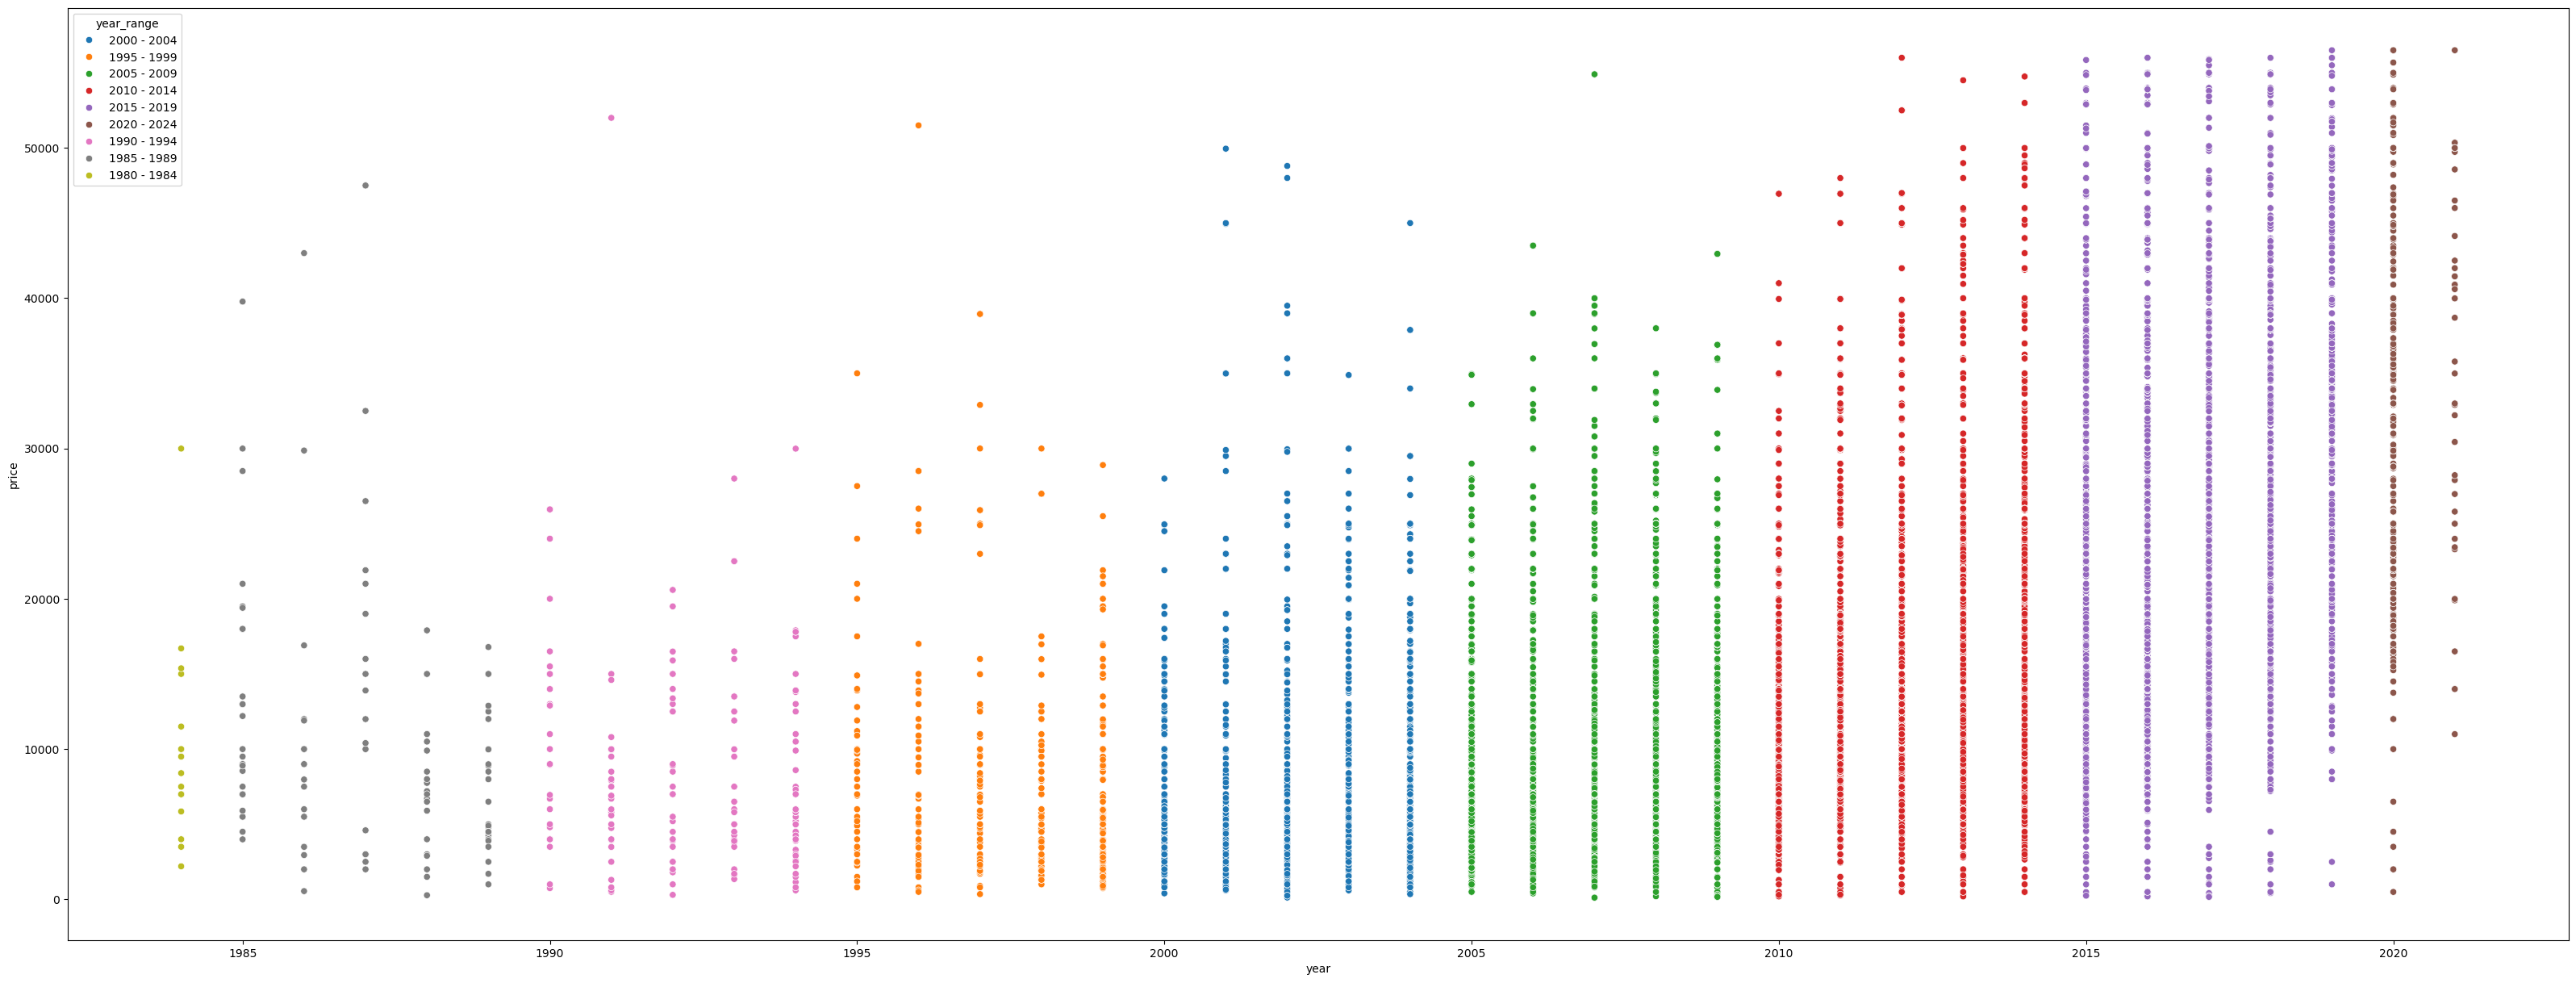

In [672]:
plt.figure(figsize=(40, 15))
threshold = 10  # Example threshold value
year_counts = df['year'].value_counts()
years_to_keep = year_counts[year_counts >= threshold].index
filtered_df = df[df['year'].isin(years_to_keep)]

# Create the scatter plot with filtered data
ax = plt.subplot()
ax = sns.scatterplot(x="year", y="price", data=filtered_df, hue='year_range')
plt.savefig('./images/price_and_year.png')

Pairplot with Drive



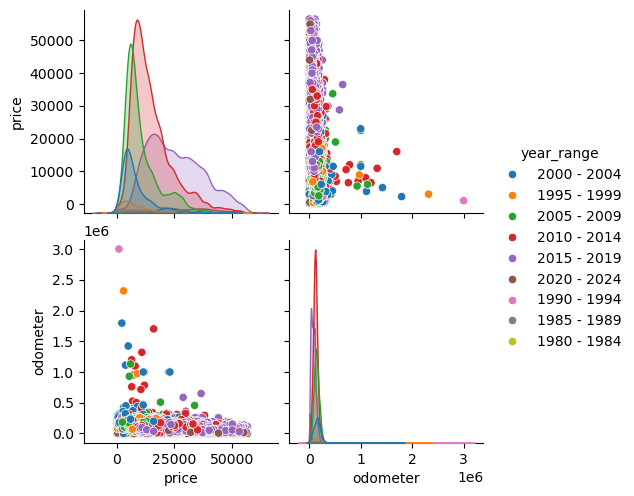

In [673]:
#Perform a pairplot with year_range
sns.pairplot(df[ ['price', 'year_range', 'type', 'odometer']], hue = 'year_range')
plt.savefig('./images/multi-pairplt.png')


## To identify the prominent and influencing data attributes, I am doing a correlation heatmap



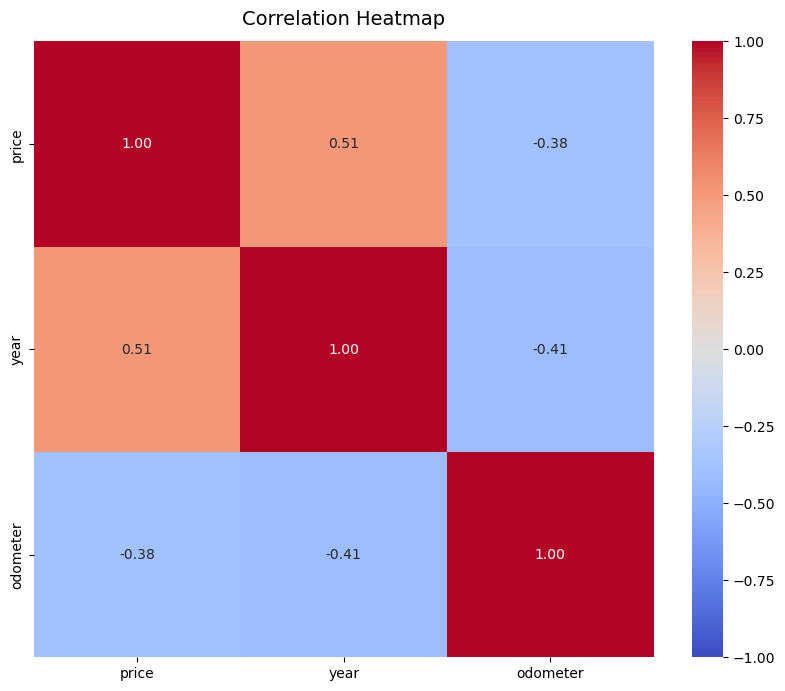

In [674]:
# selecting only valid numeric columns that we need to see in the correlation data 
numeric_df = df[['price', 'year', 'odometer']].select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(numeric_df.corr(), 
                      vmin=-1, 
                      vmax=1, 
                      annot=True, 
                      cmap='coolwarm', 
                      fmt=".2f") 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);
plt.savefig('./images/multiplot-corr-heat.png')


## Narrowing the data for model

Based on this correlation map, the strong correlating factors are year, and odometer. 
We can remove a lot of columns that has no impact on the price.


Those are 
paint_color(has a number of unique values with white being the most dominant), manufacturer( is varied), model, cylinders, type, transmission (mostly automatic), title_status all can be dropped so that we have a more narrow yet impactful dataset




In [675]:
df_after_drop = df.drop(['id', 'state', 'paint_color', 'manufacturer', 'model', 'cylinders', 'type', 'transmission', 'VIN', 'region', 'title_status'], axis=1,  inplace=False)
df_after_drop.head(5)


,price,year,condition,fuel,odometer,drive,size,year_range
215,4000,2002.0,excellent,gas,155000.0,fwd,compact,2000 - 2004
219,2500,1995.0,fair,gas,110661.0,rwd,mid-size,1995 - 1999
268,9000,2008.0,excellent,gas,56700.0,rwd,compact,2005 - 2009
337,8950,2011.0,excellent,gas,164000.0,fwd,full-size,2010 - 2014
355,9400,2008.0,good,gas,129473.0,rwd,full-size,2005 - 2009


In [676]:
#create categorical variables and drop some variables
model_df=pd.get_dummies(df_after_drop, columns=["condition","fuel","size", "drive", "year_range"], dtype=int)
model_df.head()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,...,drive_rwd,year_range_1980 - 1984,year_range_1985 - 1989,year_range_1990 - 1994,year_range_1995 - 1999,year_range_2000 - 2004,year_range_2005 - 2009,year_range_2010 - 2014,year_range_2015 - 2019,year_range_2020 - 2024
215,4000,2002.0,155000.0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
219,2500,1995.0,110661.0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
268,9000,2008.0,56700.0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
337,8950,2011.0,164000.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
355,9400,2008.0,129473.0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [677]:
model_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 30977 entries, 215 to 426833
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   30977 non-null  int64  
 1   year                    30977 non-null  float64
 2   odometer                30977 non-null  float64
 3   condition_excellent     30977 non-null  int64  
 4   condition_fair          30977 non-null  int64  
 5   condition_good          30977 non-null  int64  
 6   condition_like new      30977 non-null  int64  
 7   condition_new           30977 non-null  int64  
 8   condition_salvage       30977 non-null  int64  
 9   fuel_diesel             30977 non-null  int64  
 10  fuel_electric           30977 non-null  int64  
 11  fuel_gas                30977 non-null  int64  
 12  fuel_hybrid             30977 non-null  int64  
 13  fuel_other              30977 non-null  int64  
 14  size_compact            30977 non-null  

In [678]:
# Check if there is still bad data in the data set, i.e., unrealistic values in the attributes
data = model_df.eq(1).any()
data

price                     False
year                      False
odometer                   True
condition_excellent        True
condition_fair             True
condition_good             True
condition_like new         True
condition_new              True
condition_salvage          True
fuel_diesel                True
fuel_electric              True
fuel_gas                   True
fuel_hybrid                True
fuel_other                 True
size_compact               True
size_full-size             True
size_mid-size              True
size_sub-compact           True
drive_4wd                  True
drive_fwd                  True
drive_rwd                  True
year_range_1980 - 1984     True
year_range_1985 - 1989     True
year_range_1990 - 1994     True
year_range_1995 - 1999     True
year_range_2000 - 2004     True
year_range_2005 - 2009     True
year_range_2010 - 2014     True
year_range_2015 - 2019     True
year_range_2020 - 2024     True
dtype: bool

Generate Correlation with the new numeric data

In [679]:
model_df.corr()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,...,drive_rwd,year_range_1980 - 1984,year_range_1985 - 1989,year_range_1990 - 1994,year_range_1995 - 1999,year_range_2000 - 2004,year_range_2005 - 2009,year_range_2010 - 2014,year_range_2015 - 2019,year_range_2020 - 2024
price,1.000000,0.507738,-0.375739,-0.002388,-0.130866,-0.065815,0.140504,0.046238,-0.034617,0.415868,...,0.076572,-0.013486,-0.030531,-0.053657,-0.093370,-0.205648,-0.279193,-0.105611,0.479910,0.172192
year,0.507738,1.000000,-0.408674,0.077747,-0.171925,-0.167117,0.175594,0.047208,-0.020493,-0.008196,...,-0.141194,-0.116695,-0.275399,-0.288233,-0.349193,-0.460404,-0.393434,0.134165,0.625186,0.215010
odometer,-0.375739,-0.408674,1.000000,-0.028348,0.114546,0.135073,-0.187217,-0.047457,0.046617,0.093194,...,-0.032933,-0.007478,-0.015579,0.037824,0.087095,0.174697,0.217225,0.074619,-0.354619,-0.192291
condition_excellent,-0.002388,0.077747,-0.028348,1.000000,-0.135699,-0.743415,-0.407238,-0.076209,-0.037506,-0.031030,...,-0.091072,-0.003946,-0.025155,-0.035850,-0.037317,-0.059657,-0.038623,0.077798,0.017026,-0.027441
condition_fair,-0.130866,-0.171925,0.114546,-0.135699,1.000000,-0.081122,-0.044438,-0.008316,-0.004093,-0.014445,...,0.000720,0.008644,0.049019,0.074801,0.085562,0.105722,0.037805,-0.061693,-0.072798,-0.016147
condition_good,-0.065815,-0.167117,0.135073,-0.743415,-0.081122,1.000000,-0.243450,-0.045559,-0.022421,0.051900,...,0.101892,-0.003675,0.016266,0.034591,0.038808,0.072216,0.098391,-0.016671,-0.117394,-0.058959
condition_like new,0.140504,0.175594,-0.187217,-0.407238,-0.044438,-0.243450,1.000000,-0.024957,-0.012282,-0.016038,...,-0.001068,0.008554,-0.003243,-0.024238,-0.028834,-0.049363,-0.091677,-0.069000,0.168814,0.103670
condition_new,0.046238,0.047208,-0.047457,-0.076209,-0.008316,-0.045559,-0.024957,1.000000,-0.002298,-0.020664,...,-0.019497,-0.001601,-0.004244,-0.005673,-0.009514,-0.008964,-0.020349,-0.011166,-0.000034,0.140150
condition_salvage,-0.034617,-0.020493,0.046617,-0.037506,-0.004093,-0.022421,-0.012282,-0.002298,1.000000,-0.006701,...,-0.005219,-0.000788,0.013445,0.032175,0.009390,0.004775,0.005271,-0.017414,0.001656,-0.004463
fuel_diesel,0.415868,-0.008196,0.093194,-0.031030,-0.014445,0.051900,-0.016038,-0.020664,-0.006701,1.000000,...,0.016591,-0.002110,-0.007476,-0.013794,0.022744,-0.005532,0.009062,-0.023445,0.026792,-0.035656


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

## Applying Various Regression Models



## Linear Regression

In [680]:
model_df.iloc[0]	


price                       4000.0
year                        2002.0
odometer                  155000.0
condition_excellent            1.0
condition_fair                 0.0
condition_good                 0.0
condition_like new             0.0
condition_new                  0.0
condition_salvage              0.0
fuel_diesel                    0.0
fuel_electric                  0.0
fuel_gas                       1.0
fuel_hybrid                    0.0
fuel_other                     0.0
size_compact                   1.0
size_full-size                 0.0
size_mid-size                  0.0
size_sub-compact               0.0
drive_4wd                      0.0
drive_fwd                      1.0
drive_rwd                      0.0
year_range_1980 - 1984         0.0
year_range_1985 - 1989         0.0
year_range_1990 - 1994         0.0
year_range_1995 - 1999         0.0
year_range_2000 - 2004         1.0
year_range_2005 - 2009         0.0
year_range_2010 - 2014         0.0
year_range_2015 - 20

In [681]:
X = model_df.drop(columns = ['price'])
y = model_df['price']
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)


In [682]:
X_train


,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,...,drive_rwd,year_range_1980 - 1984,year_range_1985 - 1989,year_range_1990 - 1994,year_range_1995 - 1999,year_range_2000 - 2004,year_range_2005 - 2009,year_range_2010 - 2014,year_range_2015 - 2019,year_range_2020 - 2024
156288,2012.0,311341.0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
170113,2019.0,31871.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
121562,2015.0,166000.0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
60730,2013.0,211723.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
207522,2012.0,135897.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414856,2018.0,44500.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
82054,2014.0,112410.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10009,2019.0,23000.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
215136,2014.0,55147.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [683]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X_train,y_train)
lr.coef_[0]

1138.8093965882804

In [684]:
# Fitted model can now be used to examine the estimated coefficients and also predict ths value of the dependent
# for a given set of independent variables which in this model is the manipulated dataset
print("Coefficient of the model: ",lr.coef_)
print("Intercept of the model: ", lr.intercept_)


Coefficient of the model:  [ 1.13880940e+03 -3.52660419e-02 -3.54655041e+05 -3.57941001e+05
 -3.54950523e+05 -3.54021221e+05 -3.51738638e+05 -3.58210285e+05
 -4.14926151e+05 -4.26860584e+05 -4.29211718e+05 -4.28212468e+05
 -4.32305787e+05 -5.34408678e+05 -5.30515410e+05 -5.33490633e+05
 -5.33101987e+05 -7.07725178e+05 -7.15457045e+05 -7.08334485e+05
 -2.20164275e+05 -2.24242156e+05 -2.29326342e+05 -2.36289537e+05
 -2.41717346e+05 -2.45218866e+05 -2.47013833e+05 -2.44180646e+05
 -2.43363707e+05]
Intercept of the model:  0.0


In [685]:
# get the cofficients
[(col, coef) for col, coef in zip (X_train.columns, lr.coef_)]

[('year', 1138.8093965882804),
 ('odometer', -0.0352660418865085),
 ('condition_excellent', -354655.0410102313),
 ('condition_fair', -357941.0006017225),
 ('condition_good', -354950.5227553225),
 ('condition_like new', -354021.2205982969),
 ('condition_new', -351738.63786845846),
 ('condition_salvage', -358210.2848657422),
 ('fuel_diesel', -414926.1510287345),
 ('fuel_electric', -426860.58365600905),
 ('fuel_gas', -429211.71784296934),
 ('fuel_hybrid', -428212.4680331945),
 ('fuel_other', -432305.78713886987),
 ('size_compact', -534408.6783365948),
 ('size_full-size', -530515.4095594124),
 ('size_mid-size', -533490.6328502597),
 ('size_sub-compact', -533101.9869535124),
 ('drive_4wd', -707725.1777357691),
 ('drive_fwd', -715457.0447366931),
 ('drive_rwd', -708334.4852273181),
 ('year_range_1980 - 1984', -220164.27489255852),
 ('year_range_1985 - 1989', -224242.15560382753),
 ('year_range_1990 - 1994', -229326.34195771997),
 ('year_range_1995 - 1999', -236289.53705203455),
 ('year_range

### Compute Predictions

In [686]:
train_predictions=lr.predict(X_train)
train_predictions

array([25173.64685224, 31844.21578876, 37478.16649638, ...,
       25059.01425735, 14764.26191042, 11860.17332733])

In [687]:
#Compute Accuracy and RMSE to training model using mse
score = lr.score(X_train, y_train)
print("Accuracy: ", round(score*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y_train,train_predictions)), 2))

Accuracy:  67.37
RMSE:      6576.68


The score of the model is not strong enough to rely on. 

#### Model evaluation/ Making Predictions


In [688]:
test_predictions=lr.predict(X_test)
# Compute Accuracy and RMSE to test model
score = lr.score(X_test, y_test)
print("Accuracy: ", round(score*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y_test,test_predictions)), 2))


Accuracy:  67.6
RMSE:      6563.98


In [689]:
car_model_test = [[
    2020.0, #Year
    155000, #Odometer
    1, #condition_excellent,
    0, #condition_fair,
    0, #condition_good
    0, # condition_like new
    0, # condition new
    0, #condition_salvage,
    0, #fuel_diesel,
    0, #fuel_electric
    1, #fuel_gas
    0, #fuel_hybrid,
    0, #fuel_other,
    1, #size_compact,
    0, #size_full,
    0, #size_mid-size  ,
    0, #drive_4wd
    0, #drive_fwd
    1, #drive_fwd,
    0, #drive_rwd,
    0, #year_range_1980 - 1984  
    0, #year_range_1985 - 1989 
    0, #year_range_1990 - 1994  
    0, #year_range_1995 - 1999  
    0, #year_range_2000 - 2004 
    0, #year_range_2005 - 2009 
    0, #year_range_2010 - 2014  
    0, #year_range_2015 - 2019 
    1 #year_range_2020 - 2024  
]]

result_from_model1 = lr.predict(car_model_test)
print('\n\n')
print(f" [MODEL1 Prediction] 2020 Year Gas compact car with new condition will have a price of {result_from_model1}")

print('\n\n')




 [MODEL1 Prediction] 2020 Year Gas compact car with new condition will have a price of [17832.55576297]





###### Visualizing the initial Model performance with the actual data

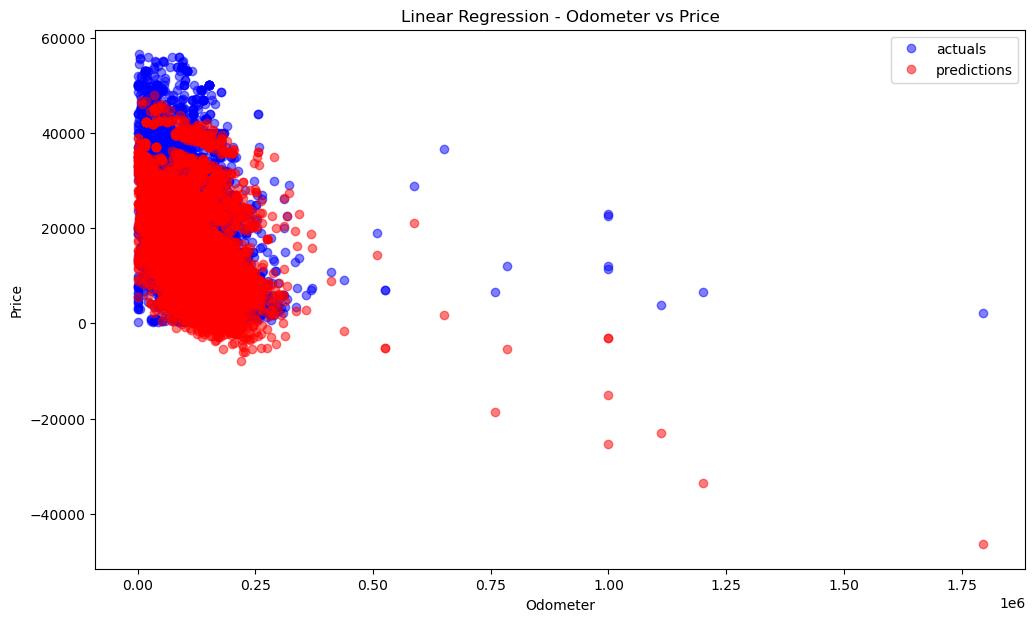

In [690]:
# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X_test.odometer, y_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X_test.odometer, test_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Odometer', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression - Odometer vs Price')
plt.savefig('./images/lr-viz-1.png')


##### Visualization of Model behavior wrt actual data (Year and Price)

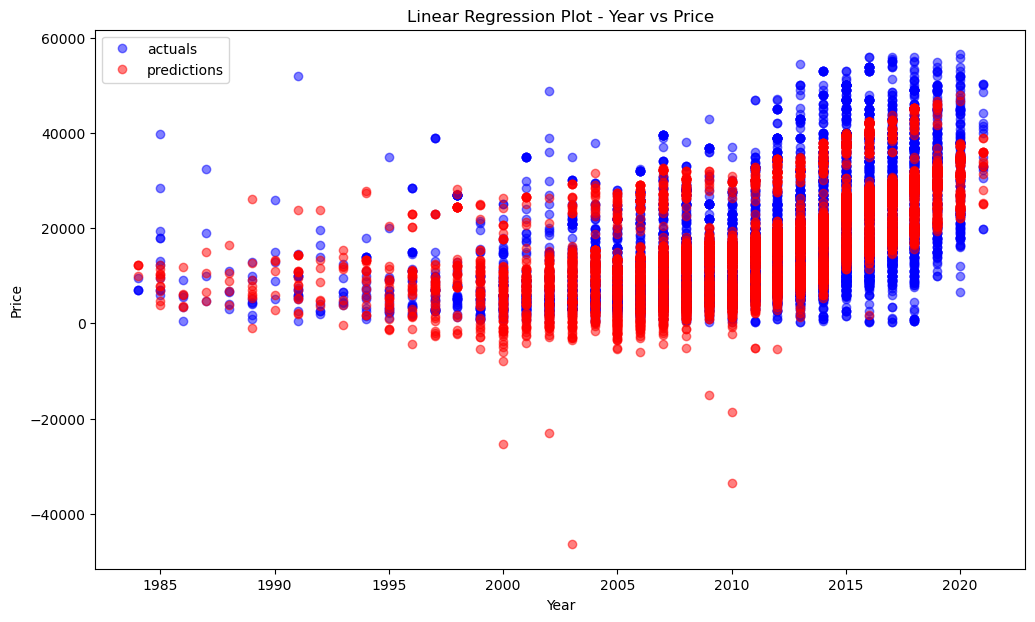

In [691]:
# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X_test.year, y_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X_test.year, test_predictions, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Year', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Plot - Year vs Price')
plt.savefig('./images/lr-viz-1-2.png')


##### Check correlation between dependent and independent features



In [692]:
np.corrcoef(y_test, test_predictions) [0][1]


0.8222785149375665

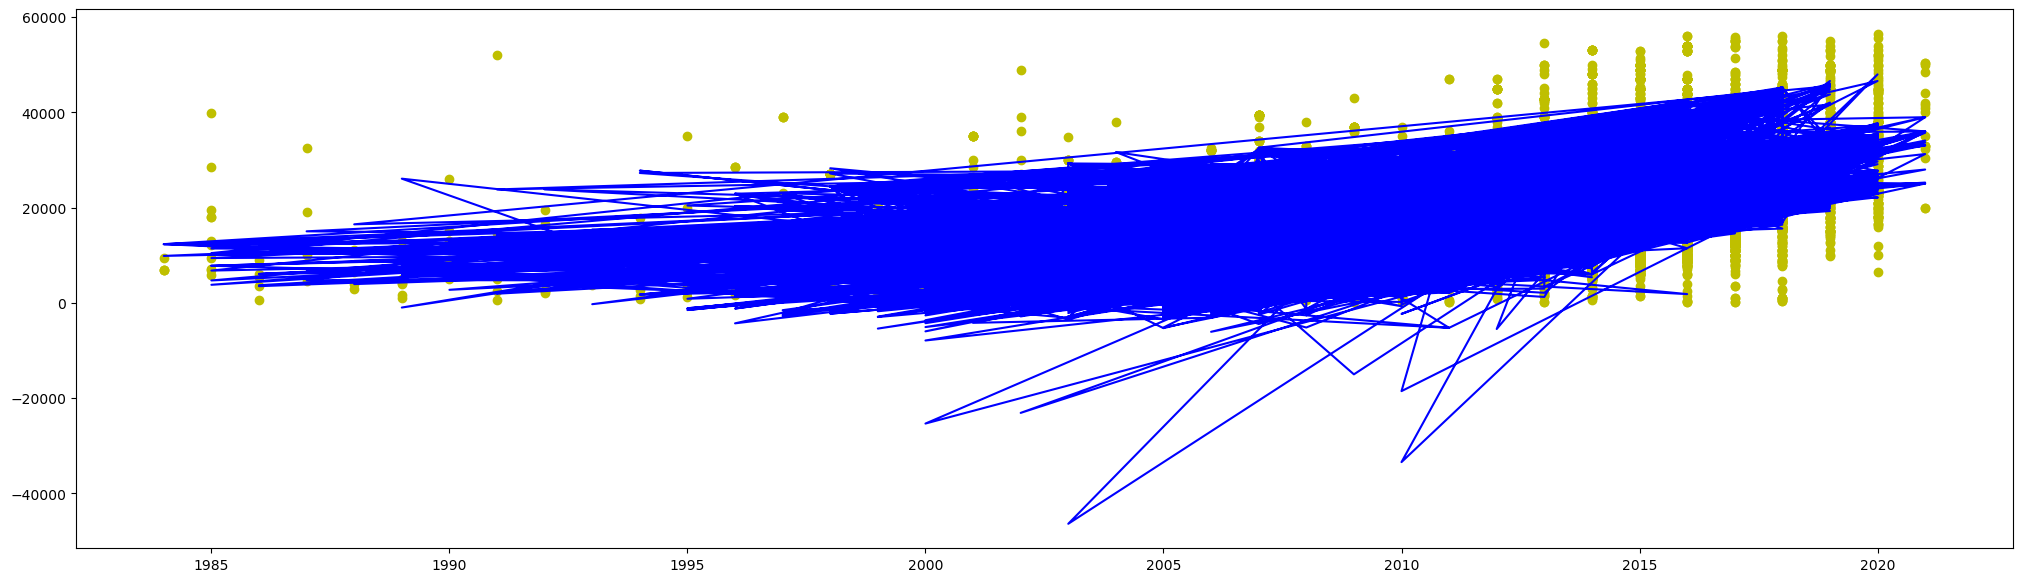

<Figure size 2500x700 with 0 Axes>

In [693]:
plt.scatter(X_test['year'], y_test,color='y') 
plt.plot(X_test['year'], test_predictions,color='b') 
plt.show()
plt.savefig('./images/lr-viz-3.png')


#### Linear Regression with limited dataset



In [694]:
# Run Regression using Odometer and Year for Price Prediction
X1 = model_df[['odometer', 'year']]
y1 = model_df.price
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, random_state = 0)

lr1=LinearRegression(fit_intercept=False)
lr1.fit(X1_train, y1_train)
print("Coefficient of the model: ",lr1.coef_)
print("Intercept of the model: ", lr1.intercept_)

Coefficient of the model:  [-0.06748286 12.01845783]
Intercept of the model:  0.0


In [722]:
result_from_model2 = lr1.predict([[155000, 2020]])
print('\n\n')
print(f" [MODEL2 Prediction] 2020 Year with odometer 155000 will have a price of {result_from_model2}")

print('\n\n')




 [MODEL2 Prediction] 2020 Year with odometer 155000 will have a price of [13817.44146003]





In [696]:
[(col, coef) for col, coef in zip (X1_train.columns, lr1.coef_)]


[('odometer', -0.06748286040479891), ('year', 12.018457833056145)]

In [697]:
# Compare with the inputs

train1_predictions=lr1.predict(X1_train)
train1_predictions

array([19318.35478274, 19021.01228244, 19993.56875791, ...,
       14124.16647398, 18000.58442421, 21406.65985479])

In [698]:
score1 = lr1.score(X1_train, y1_train)
print("Accuracy: ", round(score1*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y1_train,train1_predictions)), 2))

Accuracy:  14.63
RMSE:      10650.85


The accuracy is even lower with limited data set

In [699]:
# Use a loop to build models of degree 1 through 7 on X1_train with y1_train 
train1_mses = []
test1_mses = []
best_model_complexity1 = ''

for i in range(1, 7):
    pipe = Pipeline([('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                    ('linreg', LinearRegression())])
    pipe.fit(X1_train, y1_train)
    train1_preds = pipe.predict(X1_train)
    test1_preds = pipe.predict(X1_test)
    train1_mses.append(mean_squared_error(y1_train, train1_preds))
    test1_mses.append(mean_squared_error(y1_test, test1_preds))
    
best_model_complexity1 = test1_mses.index(min(test1_mses)) + 1

print(len(train1_mses))
print(np.round(train1_mses, 2))
print(len(test1_mses))
print(np.round(test1_mses, 2))
print(best_model_complexity1)

6
[9.37398043e+07 8.59801787e+07 8.55487813e+07 8.98628308e+07
 8.97127762e+07 1.07739825e+08]
6
[9.45640193e+07 8.69034504e+07 8.69053207e+07 1.11033881e+08
 2.90753393e+08 9.04360003e+09]
2


The Complexity that minimized Test Error was: 2
The minimal MSE was: 86903450.44113195


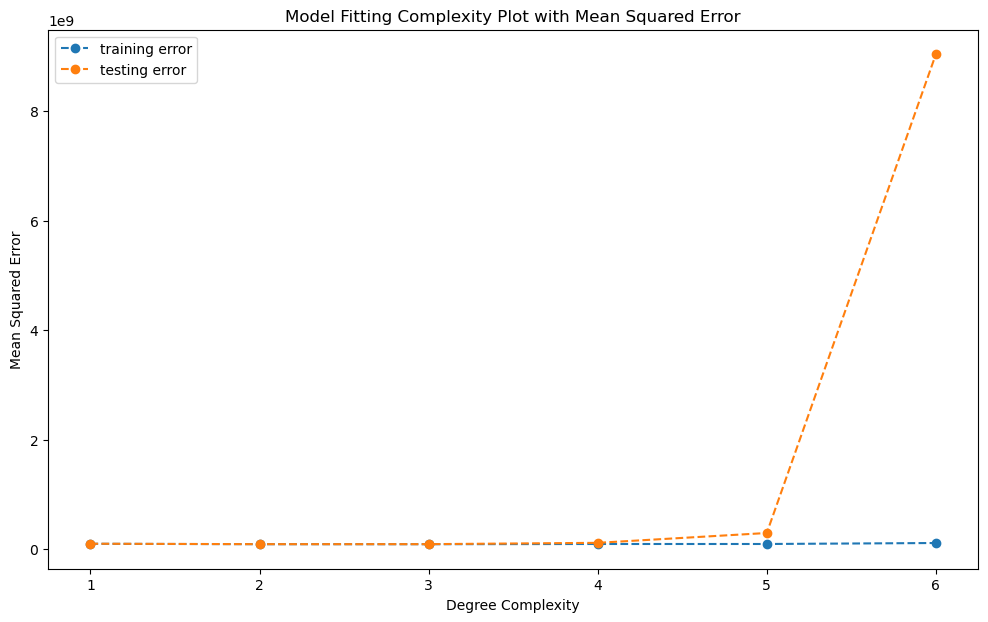

In [700]:
# visualize the results of your model fitting.
print(f'The Complexity that minimized Test Error was: {test1_mses.index(min(test1_mses)) + 1}')
print(f'The minimal MSE was: {min(test1_mses)}')
plt.figure(figsize =(12, 7))
plt.title('Model Fitting Complexity Plot with Mean Squared Error')
plt.plot(range(1, 7), train1_mses, '--o', label = 'training error')
plt.plot(range(1, 7), test1_mses, '--o', label = 'testing error')
plt.xticks(range(1, 7), range(1, 7))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

plt.savefig('./images/lr-viz-4.png')


In [701]:
#Use the sklearn.inspection modules implementation of permutation_
# importance to investigate the importance of different features to your regression models

modelR = Ridge(alpha=1e-2).fit(X1_train, y1_train)
modelR.score(X1_test, y1_test)

0.2850912621834665

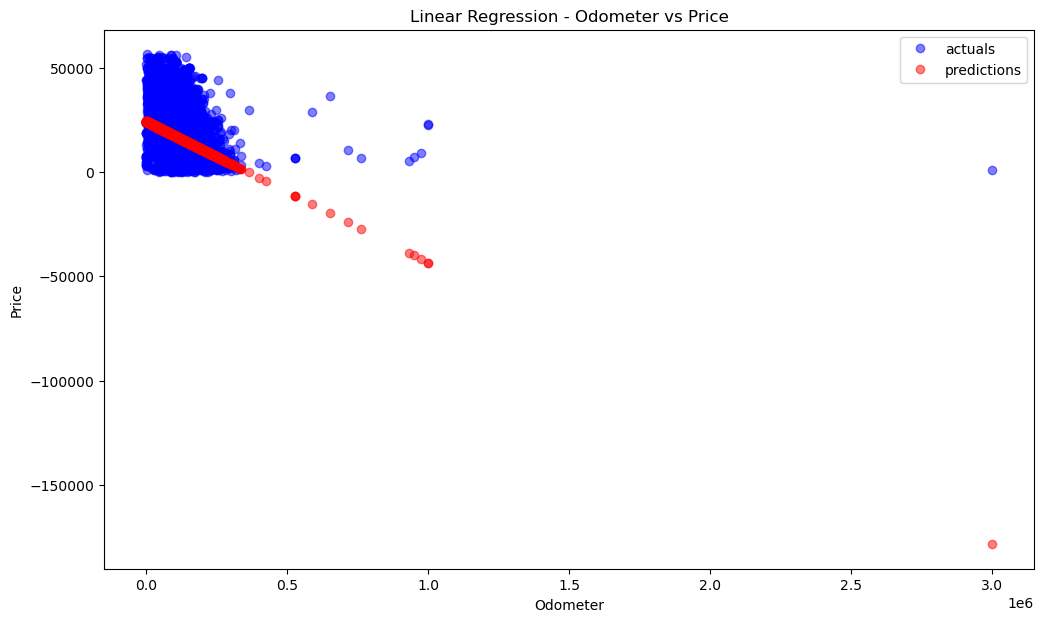

In [702]:
# Visualization of how well the model did by plotting the actual and predicted values
test_predictions1=lr1.predict(X1_test)

fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X1_test.odometer, y1_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X1_test.odometer, test_predictions1, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Odometer', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression - Odometer vs Price')
plt.savefig('./images/lr-viz-2.png')

In [703]:
X3 = model_df[['odometer',
               'fuel_diesel', 
               'year',
               'condition_fair',
               'condition_new',
               'condition_good',
               'condition_excellent',
               'drive_4wd', 
               'fuel_gas',
               'drive_rwd',
               'fuel_hybrid',
               'size_full-size',
              'size_mid-size']]
y3 = model_df.price
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.3, random_state = 0)
lr3=LinearRegression(fit_intercept=False)
lr3.fit(X3_train, y3_train)
print("Coefficient of the model: ",lr3.coef_)
print("Intercept of the model: ", lr3.intercept_)

#Let compute the predictions for the entire set of inputs
train3_predictions=lr3.predict(X3_train)

#Compute Accuracy and RMSE to training model
score3 = lr3.score(X3_train, y3_train)
print("Accuracy: ", round(score3*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y3_train,train3_predictions)), 2))

# Using the model to make predictions of Price on the test set:
test3_predictions=lr3.predict(X3_test)

# Compute Accuracy and RMSE to test model
score3 = lr3.score(X3_test, y3_test)
print("Accuracy: ", round(score3*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y3_test,test3_predictions)), 2))

Coefficient of the model:  [-7.42568516e-02  1.02485453e+04  1.10443844e+01 -8.62877720e+03
  4.36500420e+03 -3.38360040e+03 -2.18033662e+03  8.37563074e+03
 -4.35987693e+03  6.07452475e+03 -3.10742399e+03  4.69813984e+03
  8.73625307e+02]
Intercept of the model:  0.0
Accuracy:  52.62
RMSE:      7934.37
Accuracy:  50.45
RMSE:      8095.61


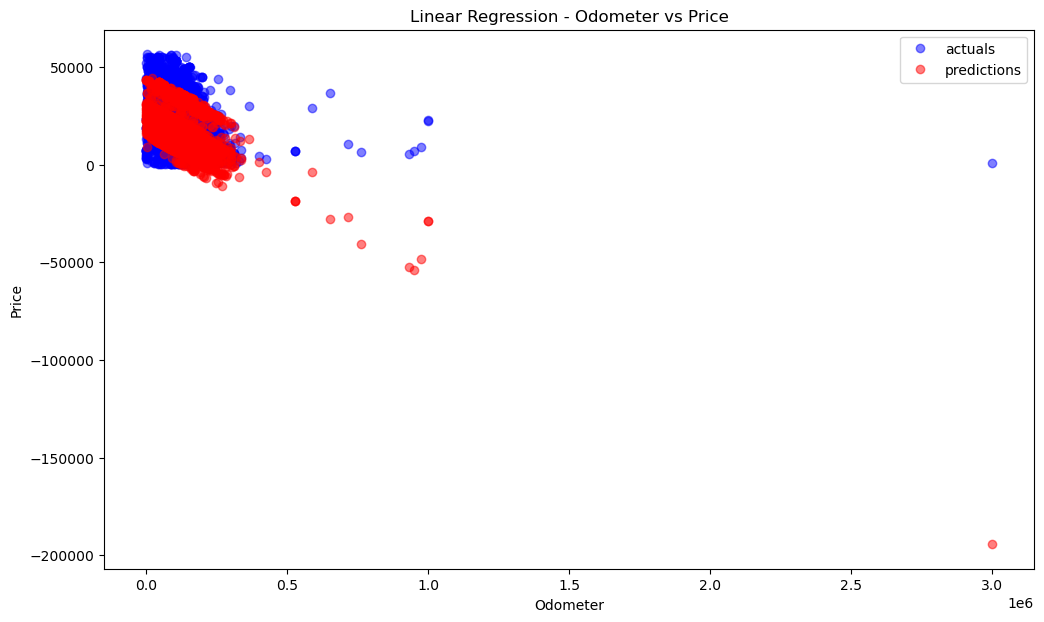

In [704]:
test_predictions3=lr3.predict(X3_test)

fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X3_test.odometer, y3_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X3_test.odometer, test_predictions3, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Odometer', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression - Odometer vs Price')
plt.savefig('./images/lr-viz-3.png')

In [721]:
test_data = [[
    155000,
    1,
    2020,
    0,
    1,
    0,
    0,
    1,
    1,
    0,
    0,
    1,
    0
]]

result_from_model3 = lr3.predict(test_data)
print('\n\n')
print(f" [MODEL3 Prediction] 2020 Year with odometer 155000, new, rwd, gas will have a price of {result_from_model3}")

print('\n\n')




 [MODEL3 Prediction] 2020 Year with odometer 155000, new, rwd, gas will have a price of [34127.28757864]





#### LR Round 4



# Run Regression using Odometer and Year for Price Prediction


In [706]:
##### 
X4 = model_df[['odometer',
                'fuel_diesel',
                'year',
                'condition_fair',
                'condition_new',
                'condition_good',
                'condition_excellent',
                'drive_4wd', 
                'fuel_gas',
                'drive_rwd',
                'fuel_hybrid',
                'size_full-size',
                'size_mid-size',
                'year_range_2000 - 2004',
                'year_range_2005 - 2009',
                'year_range_2010 - 2014',
                'year_range_2015 - 2019',
                'year_range_2020 - 2024']
              ]

X4
y4 = model_df.price
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size = 0.3, random_state = 0)

lr4=LinearRegression(fit_intercept=False)
lr4.fit(X4_train, y4_train)
print("Coefficient of the model: ",lr4.coef_)
print("Intercept of the model: ", lr4.intercept_)
test_predictions4 = lr4.predict(X4_test)
train_predictions4 =lr4.predict(X4_train)
score = lr4.score(X4_train, y4_train)
print("Accuracy: ", round(score*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y4_train,train_predictions4)), 2))

Coefficient of the model:  [-4.19159369e-02  1.40938481e+04  3.28103334e+00 -4.18120231e+03
  2.88390575e+03 -1.00448096e+03 -6.52963044e+02  7.85960502e+03
 -2.81930633e+01  7.00621008e+03  1.21899003e+03  3.85383367e+03
  7.36572479e+02  4.04638255e+02  1.89632441e+03  5.68373850e+03
  1.31661048e+04  1.83084869e+04]
Intercept of the model:  0.0
Accuracy:  66.25
RMSE:      6696.68


In [720]:
test_data = [[
    155000,
    1,
    2020,
    0,
    1,
    0,
    0,
    1,
    1,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    1
]]

result_from_model4 = lr4.predict(test_data)
print('\n\n')
print(f" [MODEL4 Prediction] 2020 Year with odometer 155000, new, rwd, gas will have a price of {result_from_model4}")

print('\n\n')




 [MODEL4 Prediction] 2020 Year with odometer 155000, new, rwd, gas will have a price of [47102.20354762]





In [708]:
### Visualization of Model 4

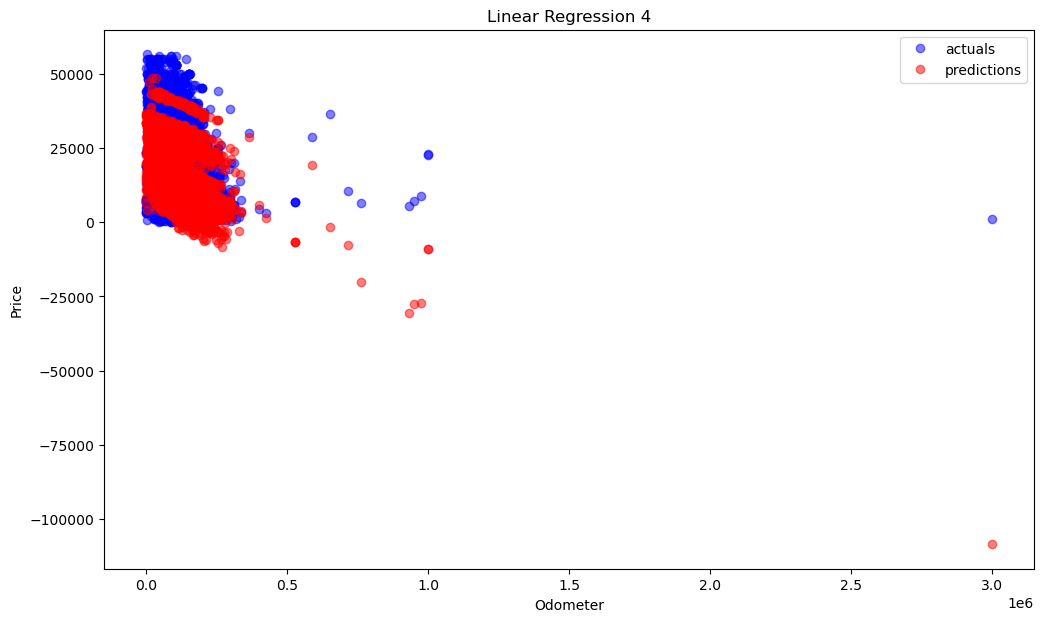

In [709]:
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X4_test.odometer, y4_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X4_test.odometer, test_predictions4, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Odometer', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression 4')
plt.savefig('./images/lr-viz-4.png')

#### LR Model 5

In [710]:

df_after_drop_round2 = df.drop(['id', 'state', 'manufacturer', 'model', 'region', 'title_status', 'state', 'cylinders', 'transmission'], axis=1,  inplace=False)

model_df_updated = pd.get_dummies(df_after_drop_round2, columns=["condition","fuel","size", "drive", 'year_range', 'paint_color', 'type'], dtype=int)
model_df_updated.head(5)


X5 = model_df.drop(columns = ['price'])

X5
y5 = model_df_updated.price
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size = 0.3, random_state = 0)

lr5=LinearRegression(fit_intercept=False)
lr5.fit(X5_train, y5_train)
print("Coefficient of the model: ",lr5.coef_)
print("Intercept of the model: ", lr5.intercept_)
test_predictions5 = lr5.predict(X5_test)
train_predictions5 =lr5.predict(X5_train)
score = lr5.score(X5_train, y5_train)
print("Accuracy: ", round(score*100, 2))
print("RMSE:     ",round(np.sqrt(mean_squared_error(y5_train,train_predictions5)), 2))

Coefficient of the model:  [ 1.14355902e+03 -3.67570698e-02 -3.55481959e+05 -3.58671534e+05
 -3.55733453e+05 -3.55019020e+05 -3.52089270e+05 -3.64214199e+05
 -4.16698507e+05 -4.29926482e+05 -4.30906745e+05 -4.29765954e+05
 -4.33911747e+05 -5.36850073e+05 -5.32862053e+05 -5.35960416e+05
 -5.35536893e+05 -7.10886929e+05 -7.18685301e+05 -7.11637206e+05
 -2.20446295e+05 -2.24682794e+05 -2.31425687e+05 -2.37519463e+05
 -2.42714206e+05 -2.46495309e+05 -2.48297455e+05 -2.45526890e+05
 -2.44101337e+05]
Intercept of the model:  0.0
Accuracy:  67.99
RMSE:      6522.29


In [711]:
X5.columns

Index(['year', 'odometer', 'condition_excellent', 'condition_fair',
       'condition_good', 'condition_like new', 'condition_new',
       'condition_salvage', 'fuel_diesel', 'fuel_electric', 'fuel_gas',
       'fuel_hybrid', 'fuel_other', 'size_compact', 'size_full-size',
       'size_mid-size', 'size_sub-compact', 'drive_4wd', 'drive_fwd',
       'drive_rwd', 'year_range_1980 - 1984', 'year_range_1985 - 1989',
       'year_range_1990 - 1994', 'year_range_1995 - 1999',
       'year_range_2000 - 2004', 'year_range_2005 - 2009',
       'year_range_2010 - 2014', 'year_range_2015 - 2019',
       'year_range_2020 - 2024'],
      dtype='object')

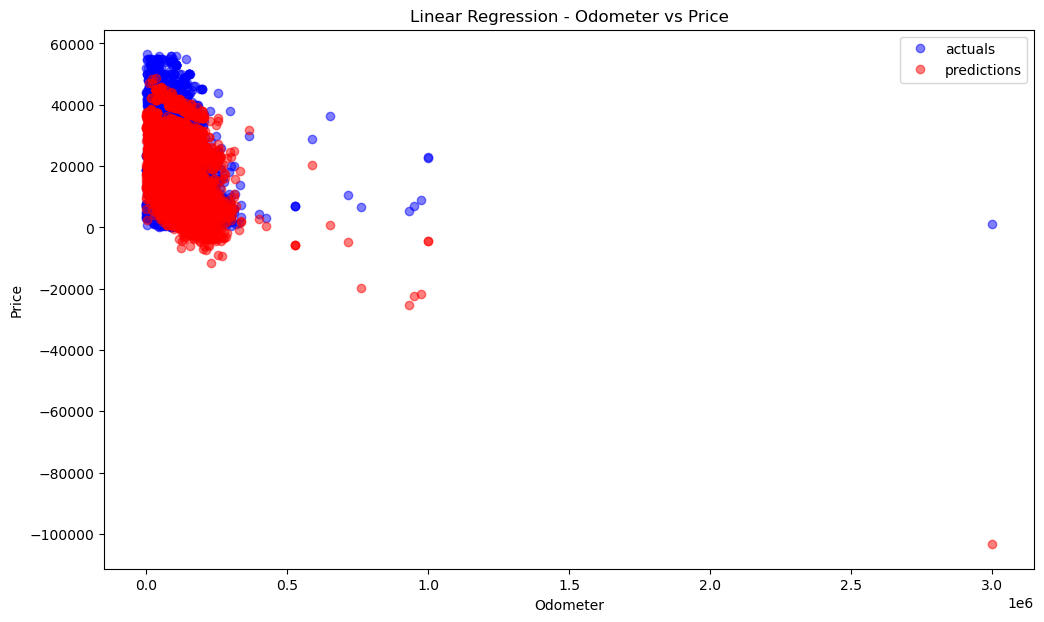

In [712]:
# Visualization of how well the model did by plotting the actual and predicted values
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X5_test.odometer, y5_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X5_test.odometer, test_predictions5, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Odometer', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression - Odometer vs Price')
plt.savefig('./images/lr-viz-5.png')

In [719]:
test_data = [[
    2020, #yead
    150000, #odometer
    1, #condition
    0,
    0,
    0,
    0,
    0,
    
    0, #fuel
    0,
    1,
    0,
    0,
    
    0, #compact
    1,
    0,
    0,
    
    0, #drive
    0,
    1,
    
    0, #year range
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1
]]

result_from_model5 = lr5.predict(test_data)
print('\n\n')
print(f" [MODEL5 Prediction] 2020 Year with odometer 155000, new, rwd, gas will have a price of {result_from_model5}")

print('\n\n')




 [MODEL5 Prediction] 2020 Year with odometer 155000, new, rwd, gas will have a price of [29486.36902796]





### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Summary

A detailed data cleaning and analysis was done to identify strong data correlation. Invalid data was removed and performed normalization (year rage etc). 

Performed multiple linear regressions with the given dataset after cleaning and narrowing down to the most relevant ones. The highest accuracy received was **69** for Model 5. Tried more linear regression models with various combinations. But the accuracy was not close enough. This indicates that car prices depend on complex, non-linear interactions between features. There is a strong correlation of varios features that all play together to influence the price of car. With more accurate and fine tuned data, the accuracy of the model can be improved as well as the price can be easily identified. 

Strongest contributing factors in the incremental orderes are 

- Year
- Condition
- Odometer
- Fuel Type
There are other factors too that influences the price, but not as strong as the above. 

### Business Insights
- Newer vehicles generally command higher prices
- Mileage has a strong negative impact on price
- Categorical features such as fuel type and transmission influence value

### How This Could Be Used
A used car dealership could:
- Adjust pricing based on predicted value
- Identify underpriced inventory
- Optimize acquisition strategy

### Limitations
- No regional pricing effects

### Next Steps
- Feature importance analysis
- Incorporating location and market trends

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.